# <a id='toc1_'></a>[2) Cars4You ML Project Price Prediction (Regression Benchmarking and Optimization)](#toc0_)
---
**Group 2:**

- Luis Mendes 20221949
- Margarida Ourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945
---

**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc2_)    
- [Data Integration](#toc3_)    
- [Modeling](#toc4_)    
    - [Benchmarking (Linear Regression)](#toc4_1_1_)    
    - [KNN](#toc4_1_2_)    
    - [Decision Tree (DT)](#toc4_1_3_)    
    - [Random Forest](#toc4_1_4_)    
    - [AdaBoost](#toc4_1_5_)    
    - [Neural Networks (NN)](#toc4_1_6_)    
    - [Analysis Final Model](#toc4_1_7_)    
      - [Final Model](#toc4_1_7_1_)    
- [Deployment (Prediction)](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Grid Search
from sklearn.model_selection import ParameterGrid
# Progress
from tqdm import tqdm
# Spliting
from sklearn.model_selection import KFold
# Preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Imputation
from sklearn.impute import KNNImputer
# Models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# CV Score and Graphing
from utils import (avg_scores,
                   graph_actual_vs_predicted, 
                   model_performance, 
                   grid_score, 
                   print_cv_results,
                   predict_test_set)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

# <a id='toc3_'></a>[Data Integration](#toc0_)

We will import the saved data created at the preprocessing step and delete the brand column, since this modeling phase is intended to create one general model for all brands.

In [5]:
# read data

# for CV
X_CV, y_CV = pd.read_pickle('../project_data/X_Ylog_ModelOptimization.pkl')
X_CV.drop(columns=['Brand'], inplace=True)

# full
X_full, y_full, scaler_full, mode_transmission_full, inputer_full = pd.read_pickle('../project_data/X_Ylog_Scale_Impute_ModelFull.pkl')
X_full.drop(columns=['Brand'], inplace=True)

# for HO
X_train_HO, X_val_HO, y_train_HO, y_val_HO, scaler_HO, transsmision_mode_HO, inputer_HO = pd.read_pickle('../project_data/Train_Val_Yslog_Scalar_Imputer_ModelHO.pkl')
X_train_HO.drop(columns=['Brand'], inplace=True)
X_val_HO.drop(columns=['Brand'], inplace=True)

# <a id='toc4_'></a>[Modeling](#toc0_)

Now we move on to the modeling phase. Based on the dataset, selected features (mileage, year of the car, trassmision type, mpg and engine size), and previous analysis on feature transformations (scaler = RobustScaler and imputer = KNN imputer with k equal to 10 and uniforms weights). We will first establish a benchmark model using Linear Regression. We will evaluate its MAE on both the training and validation sets using CV. After that, we will build additional models and compare their performance to the benchmark, assessing overfitting, complexity of the model and the MAE score on the validation set to determine if they provide any improvement.

At the end of the modeling phase, we will identify the best overall model found and compare its performance to this initial benchmark, as well as comparing all candidate models to one another.

To find the best hyperparameters for the models we are going to test, we will use Grid Search  on the Hold-Out (HO) training data. We opted for this approach because we have almost 15,000 rows available for validation, which is a significant number and provides a robust basis for evaluation. To define the range of hyperparameters to test within the Grid Search, we will first analyze arbitrary values that cause the model to clearly overfit and underfit. We will combine this empirical analysis with 'best practice rules' (when exists) to establish a robust range. We will then select the parameters that fall in the middle of this range for the final, systematic search. 

To choose the best model, we will use the same approach: (1) First, we will evaluate the Validation Mean Absolute Error (MAE), (2) then look for a model that does not overfit (we define overfitting > £200), and (3) finally, we will evaluate the model complexity, choosing a simpler model over a complex one if the MAE on the validation and overfitting are similar.

Subsequently, we will take the best model found and perform the Mean Absolute Error (MAE) evaluation using Cross-Validation (CV) to obtain a more robust final score. We opted for this approach because we want to prioritize testing more models rather than obtaining a more robust solution during the initial Grid Search phase. Since CV takes significantly more time, this approach serves as an efficient time-saver.

Let's start by defining some general parameters, such as the scores for the training and validation sets and Cross-Validation (CV) method.

In [6]:
dic_train_MAE = {}
dic_val_MAE = {}

method_CV = KFold(n_splits= 6, random_state = 22, shuffle= True)

### <a id='toc4_1_1_'></a>[Benchmarking (Linear Regression)](#toc0_)

We will fit a Linear Regression model and use it as a benchmark. We will evaluate its performance on both the training and validation sets.

In [4]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = LinearRegression(),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'LR-BeanchMark',
            log_transform= True)

6it [04:03, 40.64s/it]


In [5]:
print_cv_results('LR-BeanchMark', dic_train_MAE, dic_val_MAE)

CV Results - LR-BeanchMark
Train MAE: 3035.19, Train std: 11.87
Validation MAE: 3034.63, Validatin std: 49.57


The benchmark model achieved a MAE of £3034 on the training set and £3035 on the validation set, showing no signs of overfitting, as the validation score is almost the same as the training score. The standard deviation of the train MAE is £11 and for validation, it is £49.

Now, we are going to see the graphical difference between the actual and predicted values for the training and testing sets to analyze the model's results.

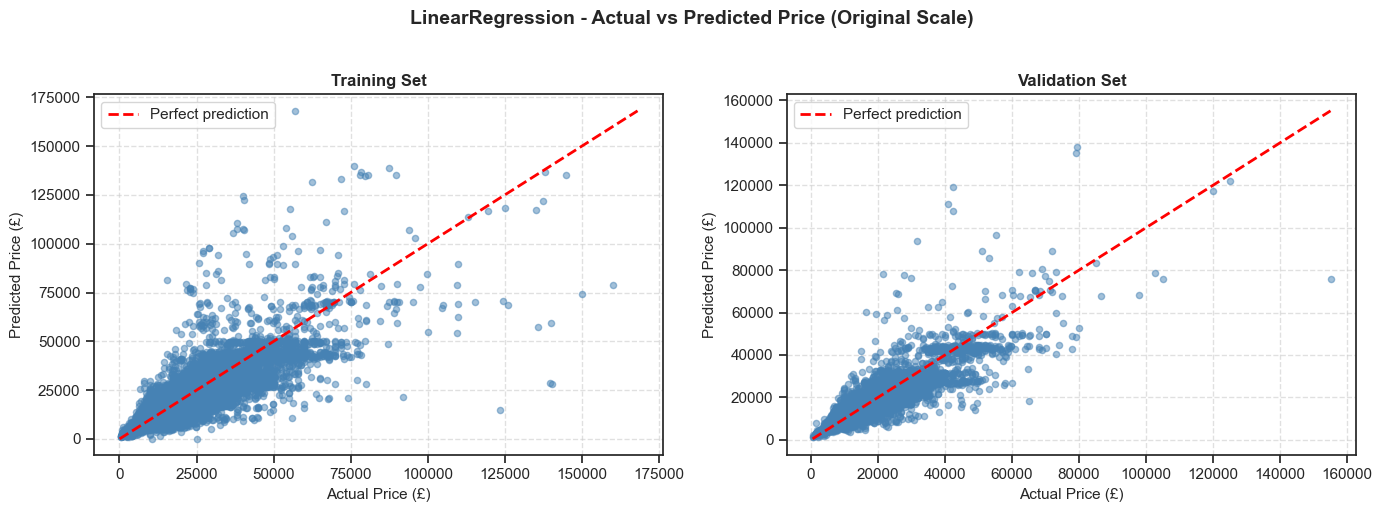

In [6]:
LR_model = LinearRegression()

graph_actual_vs_predicted(LR_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

We also see that the model's prediction error starts to increase as the price increases. We will now investigate if other types of models manage to solve this problem.

### <a id='toc4_1_2_'></a>[KNN](#toc0_)

We will test how the K-Nearest Neighbors (KNN) Regressor performs.

Now, let's analyze first on which value k the model underfits.

In [4]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=500, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2834.1396517320013
Validation MAE: 2834.8123333064377


In [13]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=100, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2554.6613049991065
Validation MAE: 2580.773769513367


In [14]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=50, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2439.199422453673
Validation MAE: 2496.183645947641


After testing with k equal to 500, 100, and 50, we see that the model does not underfit within these ranges. However, there is a clear trend that the higher the value of k, the worse the score gets. For that reason, we will set the higher ceiling of our Grid Search range to k = 100.

Now, let's see on which value of k the model overfits.

In [7]:
KNN_model_OF = KNeighborsRegressor(n_neighbors=7, weights='uniform')

model_performance(KNN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 1971.316248307592
Validation MAE: 2292.5692980160975


Starting at k=7, the model begins to exhibit overfitting (training error is significantly lower than validation error). Therefore, the lower ceiling for our Grid Search range will be k=7.

Now, let's analyze the performance using distance-weighted contributions (where closer points have a greater influence on the prediction).

In [ ]:
KNN_model_OF = KNeighborsRegressor(n_neighbors=1000, weights='distance')

model_performance(KNN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 63.79778140295198
Validation MAE: 2632.3474760301433


In [8]:
KNN_model_OF = KNeighborsRegressor(n_neighbors=2, weights='distance')

model_performance(KNN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 66.79702566684055
Validation MAE: 2348.9061914504346


We see that for a large range of k values, the model exhibits significant overfitting (using distance-weighted method). For that reason, we are not going to proceed with testing the distance-weighted method.

Now, let's find the best parameters using Grid Search , based on the lower and upper ceilings that we found.

In [9]:
# Define the parameters to test
param_grid = {'n_neighbors': list(range(7, 101))}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_knn = {}
dic_val_score_knn = {}

In [10]:
for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = KNeighborsRegressor(n_neighbors=params['n_neighbors'], weights='uniform', n_jobs=-1),
               score_train_dic = dic_train_score_knn,
               score_val_dic = dic_val_score_knn,
               dic_key = ('KNN', params['n_neighbors']),
               log_transform= True)

100%|██████████| 94/94 [07:03<00:00,  4.51s/it]


Now, let's visualize the results of the training and validation MAE scores as a function of k (the number of neighbors).

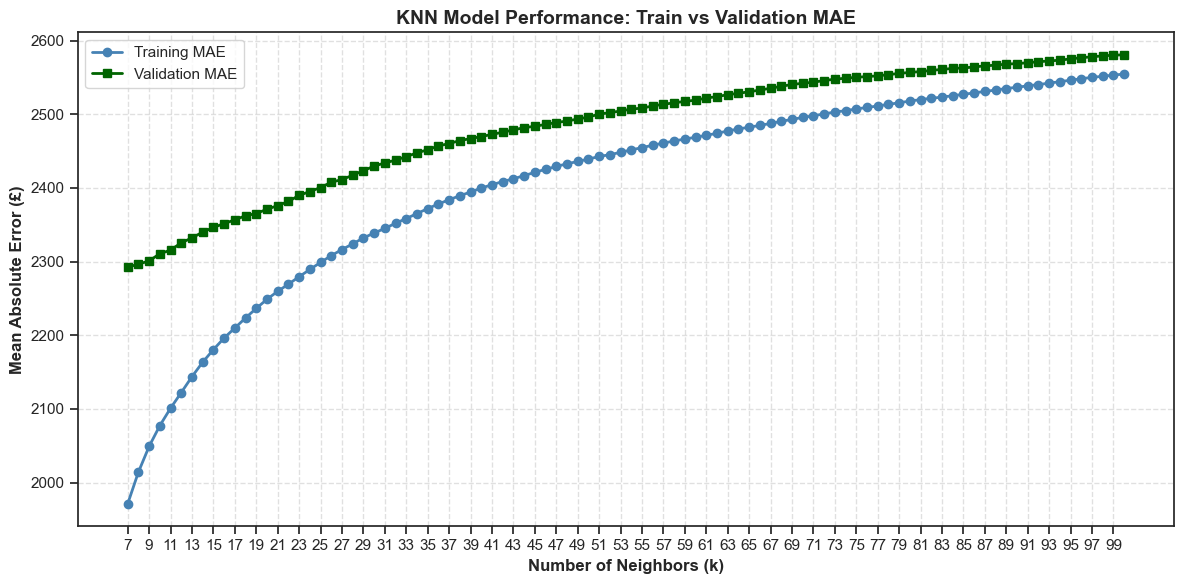

In [13]:
# Extract keys and values from dictionaries
neighbors = sorted([key[1] for key in dic_train_score_knn.keys()])
train_mae = [dic_train_score_knn[('KNN', n)] for n in neighbors]
val_mae = [dic_val_score_knn[('KNN', n)] for n in neighbors]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(neighbors, train_mae, marker='o', linewidth=2, label='Training MAE', color='steelblue')
plt.plot(neighbors, val_mae, marker='s', linewidth=2, label='Validation MAE', color='darkgreen')

plt.xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error (£)', fontsize=12, fontweight='bold')
plt.title('KNN Model Performance: Train vs Validation MAE', fontsize=14, fontweight='bold')
plt.xticks(range(7, 101, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

We see that as k increases, the difference between the training and validation MAE decreases (indicating less overfitting), but the MAE result is worse (higher). For that reason, we are going to plot the overfitting graph to analyze which model to use.

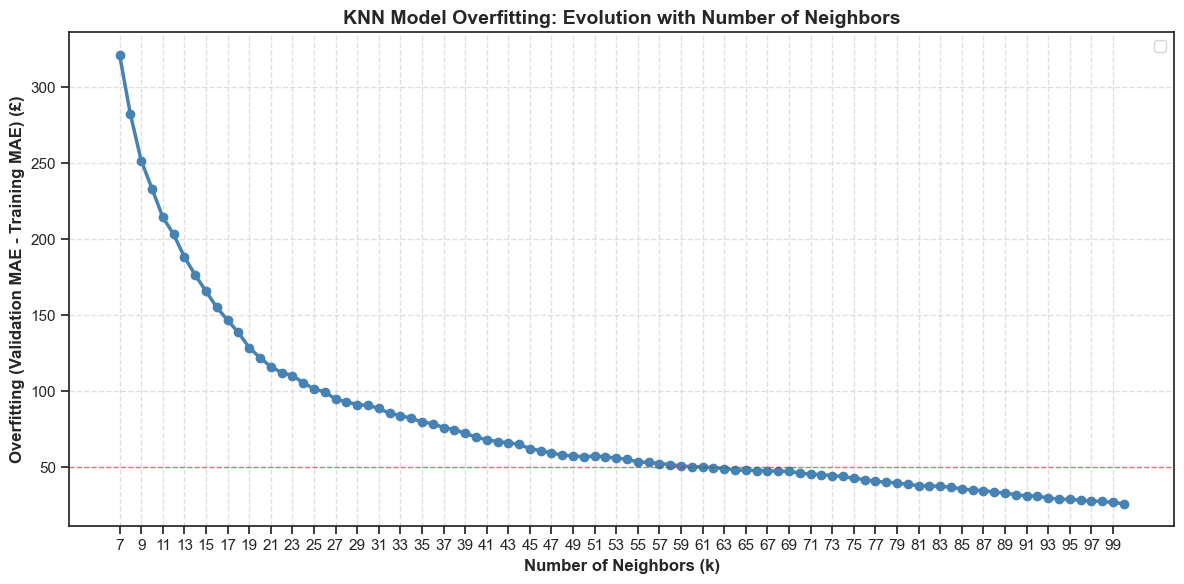

In [28]:
# Calculate overfitting (difference between validation and training MAE)
overfitting = np.subtract(val_mae, train_mae)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(neighbors, overfitting, marker='o', linewidth=2.5, markersize=6, color='steelblue')

plt.xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
plt.ylabel('Overfitting (Validation MAE - Training MAE) (£)', fontsize=12, fontweight='bold')
plt.title('KNN Model Overfitting: Evolution with Number of Neighbors', fontsize=14, fontweight='bold')
plt.axhline(y=50, color='Red', linestyle='--', linewidth=1, alpha=0.5)
plt.xticks(range(7, 101, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

After seeing the overfitting evolution, we see that the overfitting gap (difference between train and validation MAE) reaches a plateau around £50. For that reason, we are going to choose the first k when the model reaches the plateau, which should be k = 59.

Now, let's calculate a robust score for this K-Nearest Neighbors (KNN) model, using Cross-Validation (CV).

In [6]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = KNeighborsRegressor(n_neighbors=59, weights='uniform', n_jobs=-1),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'KNN',
            log_transform= True)

6it [05:28, 54.70s/it]


In [7]:
print_cv_results('KNN', dic_train_MAE, dic_val_MAE)

CV Results - KNN
Train MAE: 2458.43, Train std: 6.57
Validation MAE: 2503.04, Validatin std: 27.28


The best K-Nearest Neighbors (KNN) model achieved a mean validation MAE of £2503, with an overfitting gap (the difference between training MAE and validation MAE) of £45 on average terms.

Let's now analyze the actual vs. predicted values of that model.

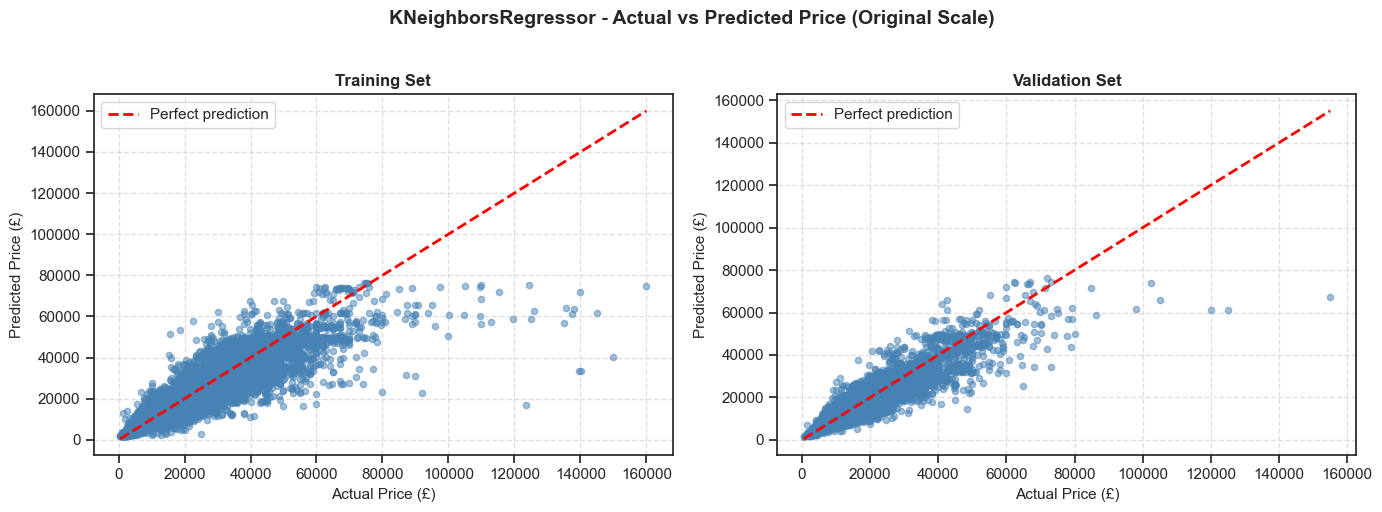

In [23]:
KNN_model = KNeighborsRegressor(n_neighbors=59, weights='uniform')

graph_actual_vs_predicted(KNN_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

We also see that the predictions are more consistent than the benchmark model, particularly as the price increases. However, the model still has a problem predicting high-value cars.

### <a id='toc4_1_3_'></a>[Decision Tree (DT)](#toc0_)

We will test how the Decision Tree (DT) Regressor performs.

Now, let's analyze on which values of depth (max_depth) and minimum samples to split (min_samples_split) the model underfits. Of course, we are going to establish 'absolute_error' as the splitting criterion, because we want to optimize for Mean Absolute Error (MAE). We are not going to test more parameters since they control overfitting in almost the same way.

In [7]:
DT_model_UF = DecisionTreeRegressor(criterion='absolute_error', 
                                     max_depth = 4,
                                     random_state = 22)

model_performance(DT_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 3384.6445557161546
Validation MAE: 3371.7563842402888


In [9]:
DT_model_UF = DecisionTreeRegressor(criterion='absolute_error', 
                                     min_samples_split = 7000,
                                     random_state = 22)

model_performance(DT_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 3513.6418542225892
Validation MAE: 3499.0697914515795


After testing with a maximum depth equal to 4, we see that the model starts to underfit. The same thing happens when we set the min_samples_split equal to 7000. So, these are going to be one set of limits for our search.

Now, let's analyze on which values of depth (max_depth) and minimum samples to split (min_samples_split) the model overfits.

In [13]:
DT_model_OF = DecisionTreeRegressor(criterion='absolute_error', 
                                     max_depth = 14,
                                     random_state = 22)

model_performance(DT_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 1566.047783742859
Validation MAE: 2268.6315069026837


In [18]:
DT_model_OF = DecisionTreeRegressor(criterion='absolute_error', 
                                     min_samples_split = 50,
                                     random_state = 22)

model_performance(DT_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 1814.9389324798678
Validation MAE: 2242.5867610189302


After testing with a maximum depth equal to 14, we see that the model starts to overfits. The same thing happens when we set the min_samples_split equal to 50. So, these are going to be the other set of limits for our search.

Now, let's find the best parameters using Grid Search , based on the lower and upper ceilings that we found. Specifically, we are going to test maximum depth (max_depth) from 4 to 14, and minimum number of samples (min_samples_split) starting at 50, 250, 500, and continuing up to 7000 in steps of 250.

In [3]:
# Define the parameters to test
param_grid = {'max_depth': list(range(4, 15)),
              'min_samples_split': [50]+list(range(250, 7001, 250))}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_DT = {}
dic_val_score_DT = {}

In [4]:
for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = DecisionTreeRegressor(criterion='absolute_error', 
                                     max_depth = params['max_depth'],
                                     min_samples_split = params['min_samples_split'],
                                     random_state = 22),
               score_train_dic = dic_train_score_DT,
               score_val_dic = dic_val_score_DT,
               dic_key = ('DT', params['max_depth'], params['min_samples_split']),
               log_transform= True)

100%|██████████| 319/319 [6:30:39<00:00, 73.48s/it]  


Now, let's visualize the results of the training and validation MAE scores for the different combinations.

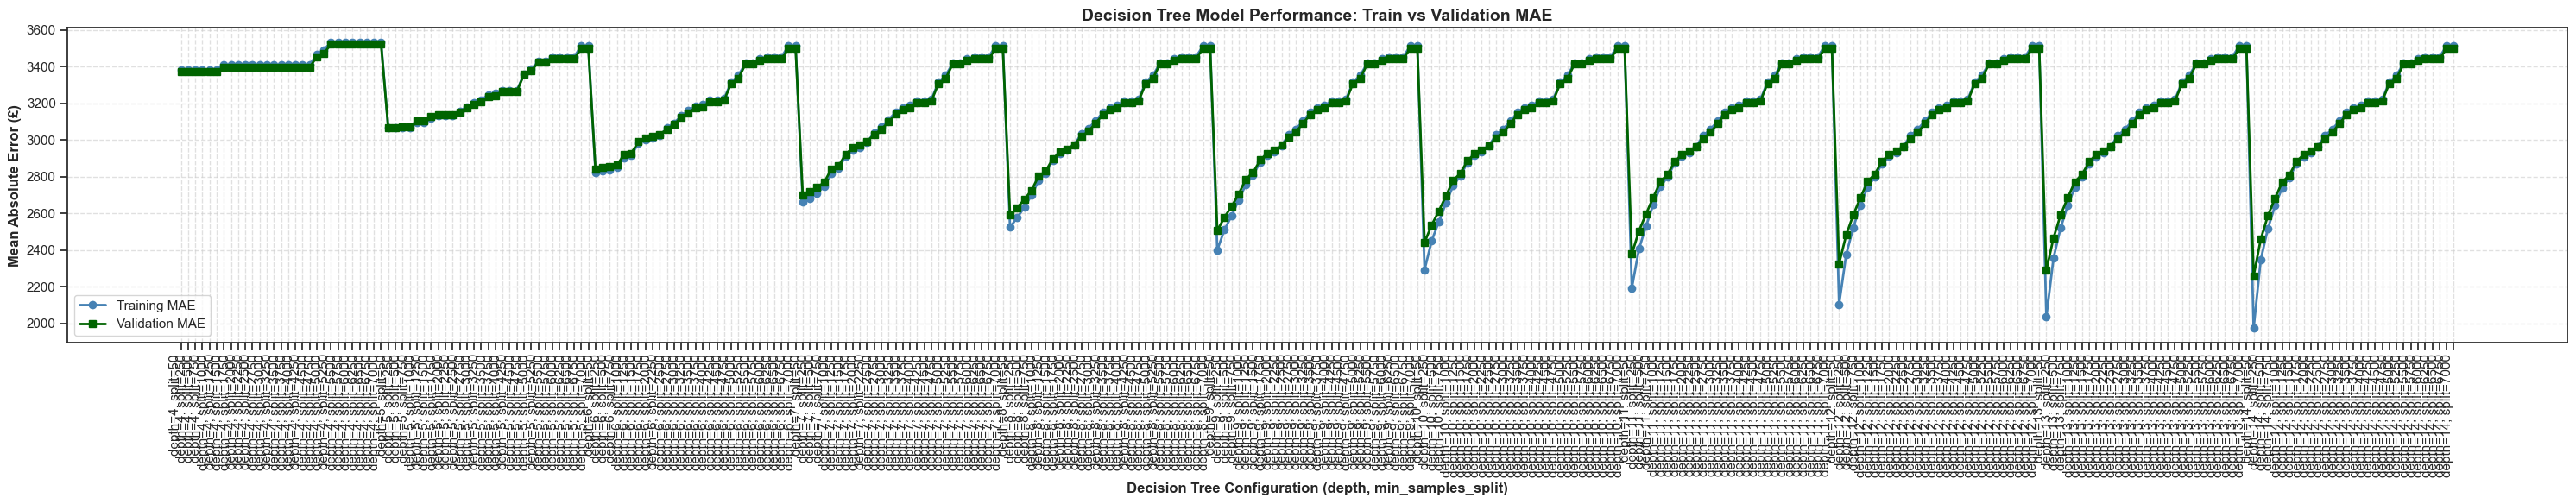

In [17]:
# Extract keys and values from dictionaries for Decision Tree (ordered by parameters)
dt_configs = sorted(dic_train_score_DT.keys())
train_mae_dt = [dic_train_score_DT[config] for config in dt_configs]
val_mae_dt = [dic_val_score_DT[config] for config in dt_configs]

# Create meaningful x-axis labels from configurations
config_labels = [f"depth={config[1]}, split={config[2]}" for config in dt_configs]
x_positions = np.arange(len(dt_configs))

# Create the plot
plt.figure(figsize=(30, 6))
plt.plot(x_positions, train_mae_dt, marker='o', linewidth=2, label='Training MAE', color='steelblue')
plt.plot(x_positions, val_mae_dt, marker='s', linewidth=2, label='Validation MAE', color='darkgreen')

plt.xlabel('Decision Tree Configuration (depth, min_samples_split)', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error (£)', fontsize=12, fontweight='bold')
plt.title('Decision Tree Model Performance: Train vs Validation MAE', fontsize=14, fontweight='bold')
plt.xticks(x_positions, config_labels, rotation=90, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

We see that after each depth increased, the model performs a little better. For that reason and to visualize the scores and parameters better, we are going to have one visualization per depth tested.

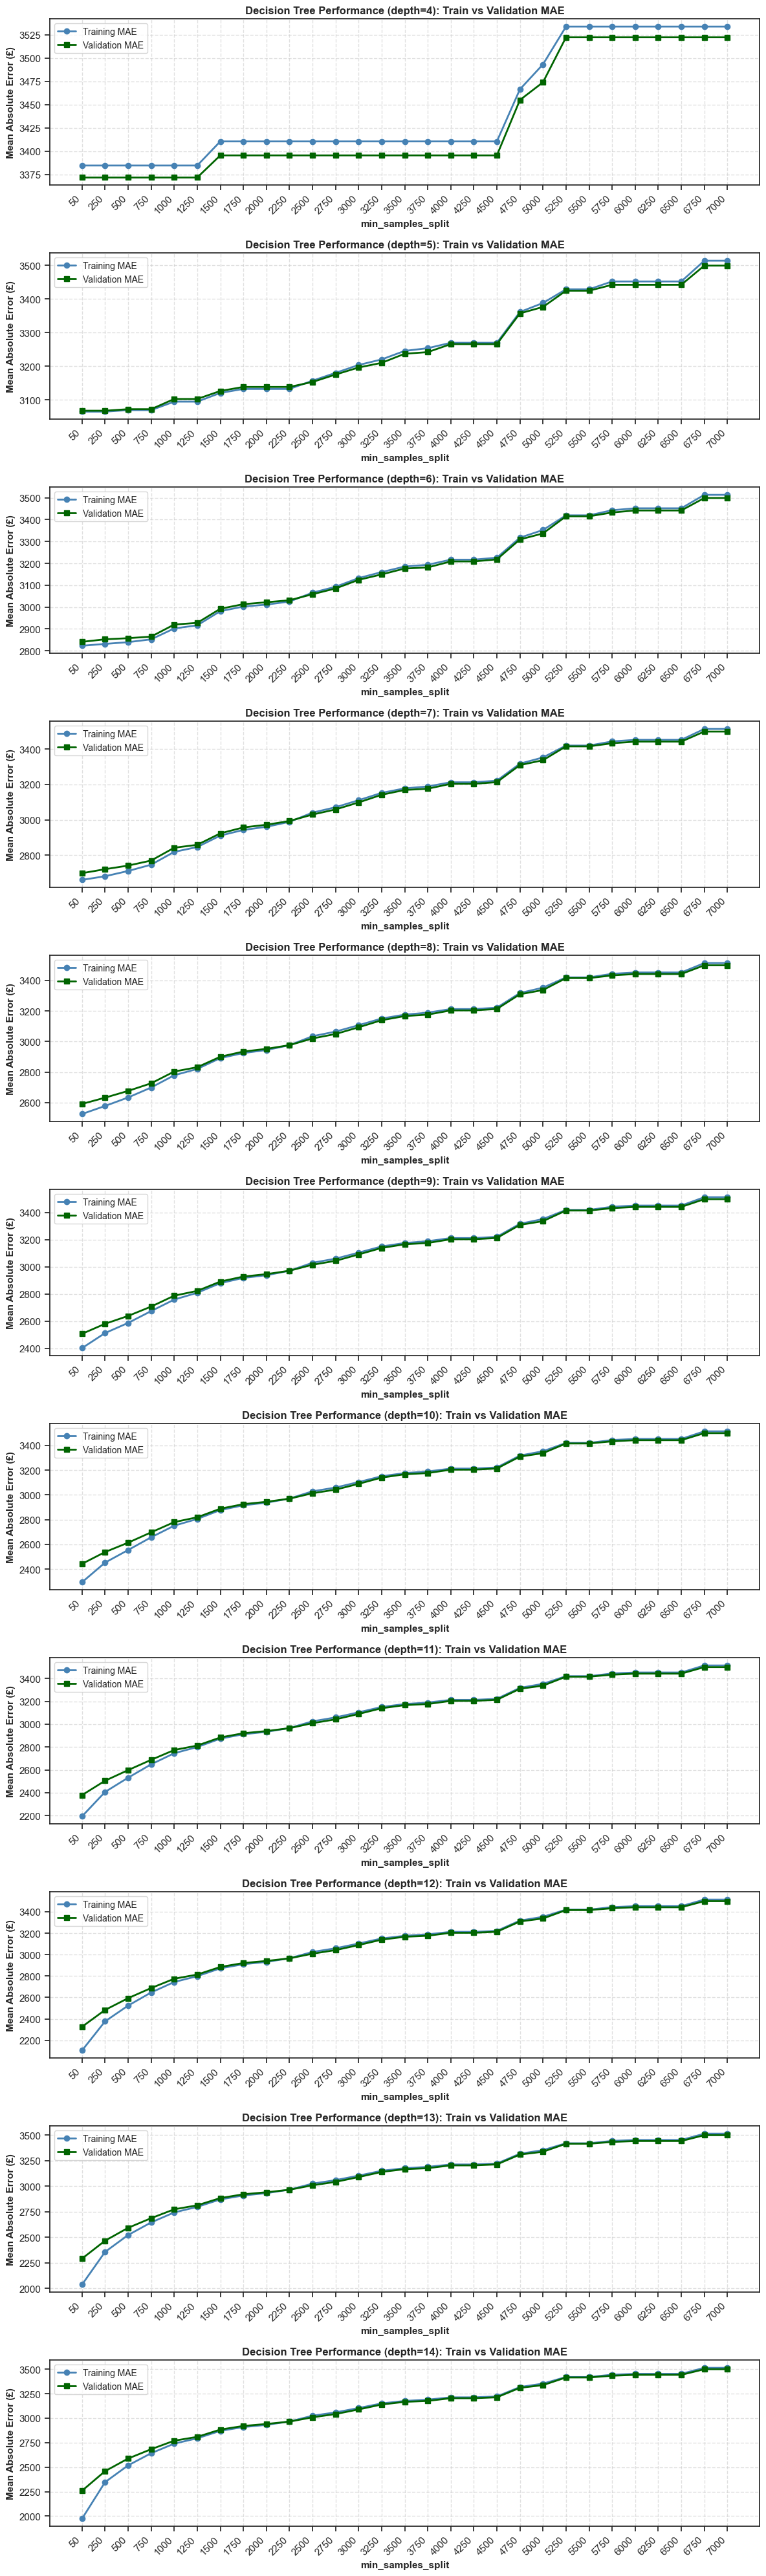

In [27]:
# Extract unique depths and organize data by depth
dt_configs = sorted(dic_train_score_DT.keys())
unique_depths = sorted(set(config[1] for config in dt_configs))

# Create a subplot for each depth value
fig, axes = plt.subplots(11, 1, figsize=(12, 40))

# Handle case where there's only one depth (axes won't be an array)
for idx, depth in enumerate(unique_depths):
    # Filter configs for this depth
    depth_configs = [config for config in dt_configs if config[1] == depth]
    
    # Extract MAE values for this depth
    train_mae_depth = [dic_train_score_DT[config] for config in depth_configs]
    val_mae_depth = [dic_val_score_DT[config] for config in depth_configs]
    
    # Extract split values for x-axis
    split_values = [config[2] for config in depth_configs]
    x_positions = np.arange(len(split_values))
    
    # Create the plot for this depth
    axes[idx].plot(x_positions, train_mae_depth, marker='o', linewidth=2, label='Training MAE', color='steelblue')
    axes[idx].plot(x_positions, val_mae_depth, marker='s', linewidth=2, label='Validation MAE', color='darkgreen')
    
    axes[idx].set_xlabel('min_samples_split', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Mean Absolute Error (£)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Decision Tree Performance (depth={depth}): Train vs Validation MAE', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x_positions)
    axes[idx].set_xticklabels(split_values, rotation=45, ha='right')
    axes[idx].grid(True, linestyle='--', alpha=0.6)
    axes[idx].legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()

It is clear that at fewer depth values, the model underfits and does not effectively use the min_samples_split hyperparameter. However, as the depth increases, the min_samples_split starts to have some importance on the fitness of the model. 

We are now going to analyze in more detail the depths from 11 to 14 and min_samples_split values of [250, 500, 750, 1000]. We chose this narrowed search space because these options yield the best scores without the extreme overfitting seen at very low min_samples_split values (like 50).

In [ ]:
# Filter configurations for depth 11-14 and min_samples_split in [250, 500, 750, 1000]
dt_configs = sorted(dic_train_score_DT.keys())
filtered_configs = [config for config in dt_configs 
                    if config[1] in [11, 12, 13, 14] 
                    and config[2] in [250, 500, 750, 1000]]

# Create lists for the dataframe
data = []
for config in filtered_configs:
    data.append({
        'max_depth': config[1],
        'min_samples_split': config[2],
        'train_mae': dic_train_score_DT[config],
        'val_mae': dic_val_score_DT[config],
        'overfitting': dic_val_score_DT[config] - dic_train_score_DT[config]
    })

# Create dataframe
df_dt_models = pd.DataFrame(data)

# Sort by validation MAE to see best models
df_dt_models = df_dt_models.sort_values('val_mae').reset_index(drop=True)

df_dt_models

,max_depth,min_samples_split,train_mae,val_mae,overfitting
0,14,250,2346.972830,2459.177423,112.204593
1,13,250,2356.274468,2466.073806,109.799338
2,12,250,2376.704281,2483.228917,106.524636
3,11,250,2406.622083,2504.799284,98.177201
4,14,500,2518.095413,2587.883423,69.788010
5,13,500,2521.615029,2592.077941,70.462912
6,12,500,2523.992532,2593.262072,69.269540
7,11,500,2531.335002,2597.769755,66.434753
8,14,750,2642.259240,2683.303929,41.044689
9,13,750,2644.932962,2686.654066,41.721105


After reviewing the results, we considered the best model to be the one with a maximum depth of 11 and minimum samples of 250, because it achieved a good value for MAE on the validation (£2504), the overfitting gap is just £98, and it is a simpler model compared to the others that have more depth but achieve almost the same results on MAE of the validation.

Now, let's calculate a robust score for this Decision Tree (DT) model, using Cross-Validation (CV).

In [8]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = DecisionTreeRegressor(criterion='absolute_error', 
                                     max_depth = 11,
                                     min_samples_split = 250,
                                     random_state = 22),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'DT',
            log_transform= True)

6it [15:51, 158.52s/it]


In [9]:
print_cv_results('DT', dic_train_MAE, dic_val_MAE)

CV Results - DT
Train MAE: 2390.33, Train std: 11.53
Validation MAE: 2477.05, Validatin std: 30.0


The best Decision Tree (DT) model achieved a mean validation MAE of £2477, with an overfitting gap (the difference between training MAE and validation MAE) of £87 on average terms.

Let's now analyze the actual vs. predicted values of that model.

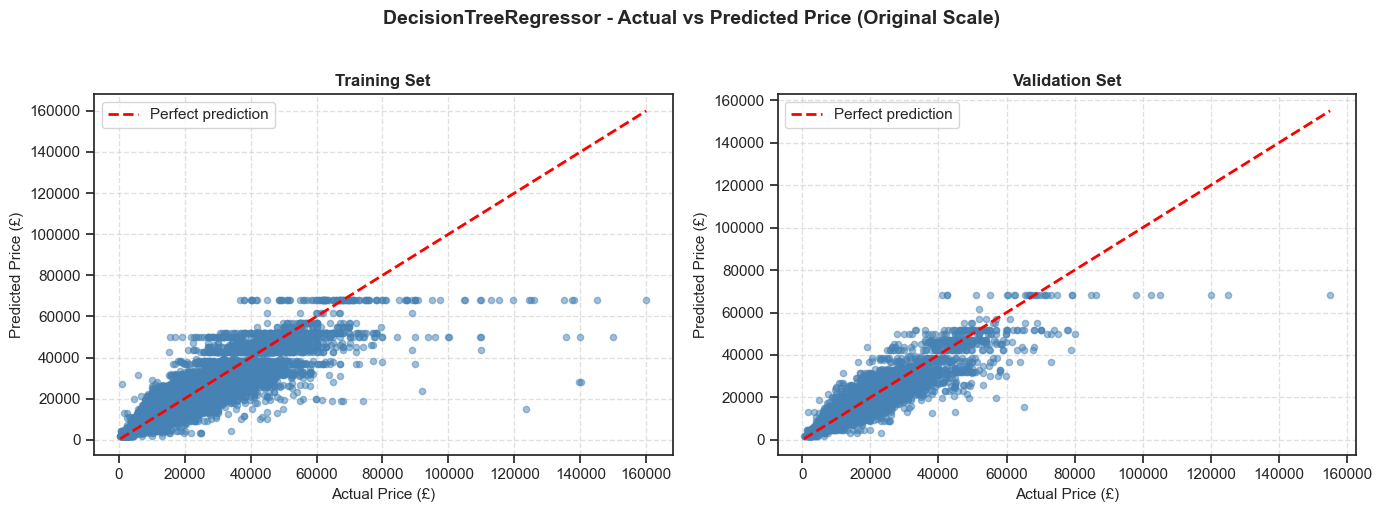

In [32]:
DT_model = DecisionTreeRegressor(criterion='absolute_error', 
                                     max_depth = 11,
                                     min_samples_split = 250,
                                     random_state = 22)

graph_actual_vs_predicted(DT_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

After seeing the predictions, we see that the model predicts well for the training and validation sets. However, a limitation of the model is that it predicts a large group of observations with the same value, meaning that it is not capturing the underlying structure of the data, even though it has a good score.

Now, let's analyze the Decision Tree using a post-pruning technique specifically the cost-complexity parameter, ccp_alpha.

In [ ]:
dt_alpha = DecisionTreeRegressor(random_state=22)

# Compute pruning path
path = dt_alpha.cost_complexity_pruning_path(X_train_HO, y_train_HO)

# Extract alphas and impurities
ccp_alphas = path.ccp_alphas

print("Number of alphas:", len(ccp_alphas))

Number of alphas: 41066


There are 41,066 values for ccp_alpha to test, but we are not going to test all of them. We looked (by trial and error) for a range of ccp_alpha values that yielded meaningful results (with no excessive overfitting and a validation MAE score lower than £2700). We found that the values higher than 2.6e-6 and lower than 0.005 satisfy those conditions. Therefore, we are going to train our Decision Tree on this interval of values and analyze the results.

The trial-and-error approach was necessary because the values for ccp_alpha are not uniformly separated (they are often very close together at low values). Therefore, we could not test all the values with a certain interval, because we would have ended up with more bad results than meaningful ones.

In [ ]:
# Fix negatives
ccp_alphas = np.array([alpha for alpha in ccp_alphas if alpha >= 0])

# Filter alphas within a specific range and sample every 100th alpha
ccp_alphas_samples = ccp_alphas[(ccp_alphas >= 2.6e-6) & (ccp_alphas <= 0.005)][::100]

trees = []
for alpha in tqdm(ccp_alphas_samples):
    model = DecisionTreeRegressor(random_state=22, ccp_alpha=float(alpha))
    model.fit(X_train_HO, y_train_HO)
    trees.append(model)

100%|██████████| 21/21 [07:46<00:00, 22.23s/it]


Now that we've tested 21 possible alphas, we are going to see the values for the training and validation MAE and the overfitting gap, and then conclude about this post-pruning optimization approach.

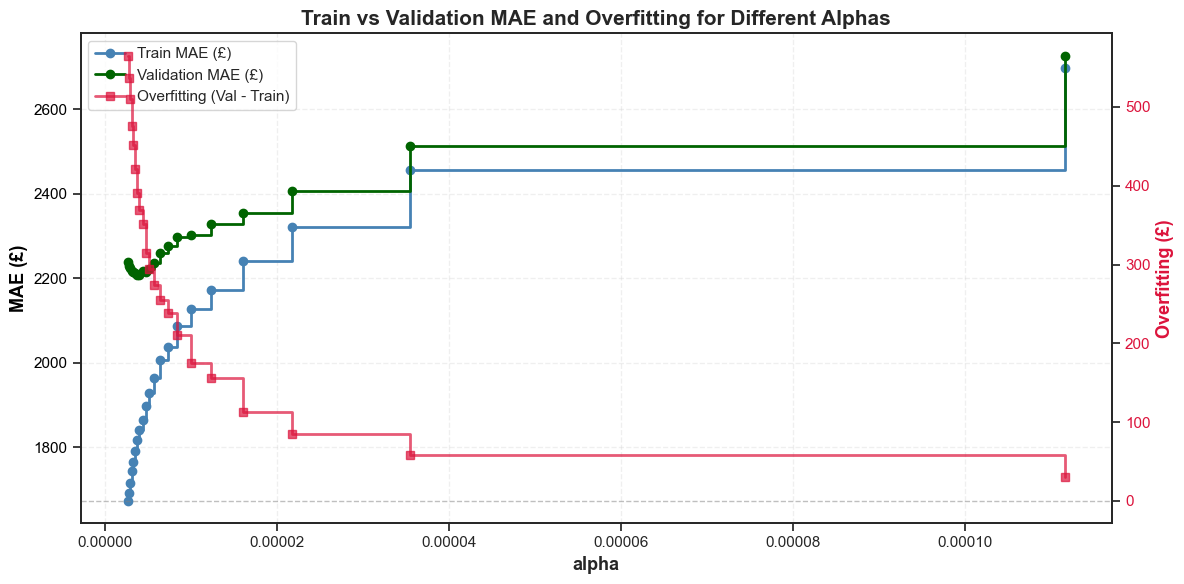

In [55]:
train_mae = [
    mean_absolute_error(
        np.exp(y_train_HO),
        np.exp(tree.predict(X_train_HO))
    )
    for tree in trees 
]

val_mae = [
    mean_absolute_error(
        np.exp(y_val_HO),
        np.exp(tree.predict(X_val_HO))
    )
    for tree in trees
]

# Calculate overfitting (difference between validation and training MAE)
overfitting = np.subtract(val_mae, train_mae)

# Create figure with primary and secondary y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot train and validation MAE on primary y-axis
ax1.plot(ccp_alphas_samples, train_mae, marker='o', label="Train MAE (£)", drawstyle="steps-post", color='steelblue', linewidth=2)
ax1.plot(ccp_alphas_samples, val_mae, marker='o', label="Validation MAE (£)", drawstyle="steps-post", color='darkgreen', linewidth=2)
ax1.set_xlabel("alpha", fontsize=13, fontweight='bold')
ax1.set_ylabel("MAE (£)", fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.3)

# Create secondary y-axis for overfitting
ax2 = ax1.twinx()
ax2.plot(ccp_alphas_samples, overfitting, marker='s', label="Overfitting (Val - Train)", drawstyle="steps-post", color='crimson', linewidth=2, alpha=0.7)
ax2.set_ylabel("Overfitting (£)", fontsize=13, fontweight='bold', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

plt.title("Train vs Validation MAE and Overfitting for Different Alphas", fontsize=15, fontweight='bold')
fig.tight_layout()
plt.show()

We can conclude the following things:
+ **Correct Search Space:** The search space for the ccp_alpha values was the correct one, since we successfully captured models with a lot of overfitting (small alphas), and models with a poor MAE (high values for alpha).
+ **Performance Comparison:** If we evaluate for similar overfitting to the model found using pre-pruning techniques (which had roughly £100 on overfitting), the score on training and validation MAE are almost the same (around £2400 on MAE).
+ **Final Decision:** We could try a model with more overfitting around £200), but the trade-off between overfitting and validation MAE is not significant (it doesn't breach the £2000 barrier). For that reason, we are not going to keep trying to find a better model for the Decision Tree (DT), and will keep as our solution for the DT the one found using pre-pruning techniques (max_depth=11, min_samples_split=250).

### <a id='toc4_1_4_'></a>[Random Forest](#toc0_)

We will test how the Random Forest (RF) Regressor performs.

To test it, we are going to use what we learned on the Decision Tree (DT). We are going to test hyperparameters that are close to overfitting, underfitting, and a value in the middle.

Specifically, we will test the maximum depth of 4, 14, and no maximum depth. The minimum samples will be 2, 50, and 500, which were the values where we saw jumps in the DT performance.

For the maximum features, we will try two combinations: either half of the features to consider for the split, or all the features **(bagging of DT)**.

For the estimators, we will test a small number of them (25), a large number (150), and something in the middle (50 and 100).

For the max_samples, we will test a small number of them(33%), a large number (100%), and something in the middle (66%).

We will evaluate the splits using the Absolute Error since that is the metric we want to optimize, and we will use bootstrapping because that is what will guarantee the variability of results in our Random Forest (RF) (sampling different data points for each tree).

In [ ]:
# Define the parameters to test
param_grid = {
    "n_estimators": [25, 50, 100, 200],
    "max_samples" : [0.33, 0.66, 1.0],        
    "max_depth": [4, 14, None],          
    "min_samples_split": [2, 50, 500],    
    "max_features": [3, 6]
}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_RF = {}
dic_val_score_RF = {}

In [ ]:
for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = RandomForestRegressor(random_state=22,
                                n_estimators = params['n_estimators'],
                                max_depth= params['max_depth'],
                                min_samples_split= params['min_samples_split'],
                                max_features= params['max_features'],
                                max_samples= params['max_samples'],
                                bootstrap=True,
                                criterion='absolute_error',
                                n_jobs=-1),
               score_train_dic = dic_train_score_RF,
               score_val_dic = dic_val_score_RF,
               dic_key = ('RF', params['n_estimators'], params['max_depth'], params['min_samples_split'], params['max_features'], params['max_samples']),
               log_transform= True)

Now we will order the results by the values of the validation MAE, and see the results.

In [ ]:
rows = []
for key in dic_train_score_RF.keys():
    # key format: ('RF', n_estimators, max_depth, min_samples_split, max_features and max_samples)
    _, n_estimators, max_depth, min_samples_split, max_features, max_samples = key
    train_mae = float(dic_train_score_RF[key])
    val_mae = float(dic_val_score_RF[key])
    rows.append({
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "max_features": max_features,
        "max_samples": max_samples,
        "train_mae": train_mae,
        "val_mae": val_mae,
        "overfitting": val_mae - train_mae
    })

df_rf_models = pd.DataFrame(rows)
df_rf_models = df_rf_models.sort_values("val_mae").reset_index(drop=True)

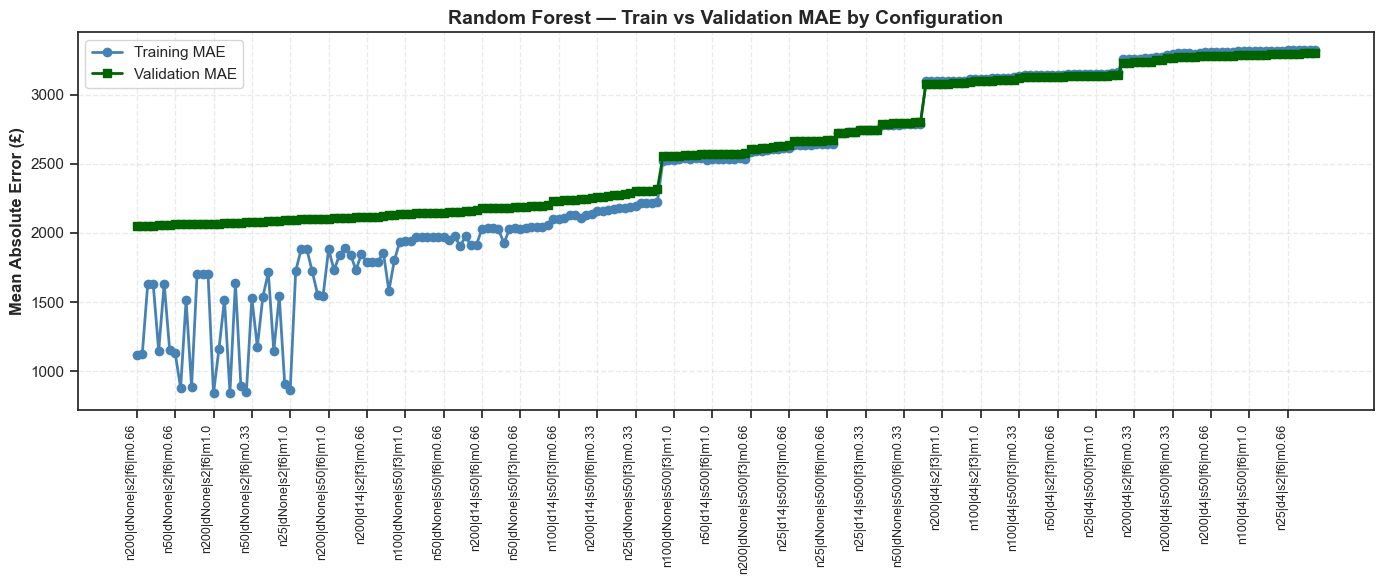

In [ ]:
dic_val_score_RF = dict(sorted(
    dic_val_score_RF.items(), 
    key=lambda item: item[1]
))

dic_train_score_RF = {key: dic_train_score_RF[key] for key in dic_val_score_RF}

# Ordered keys (dictionaries are already sorted)
rf_keys = list(dic_train_score_RF.keys())

# Extract MAE values (values are scalars = means)
train_mae = [dic_train_score_RF[k] for k in rf_keys]
val_mae   = [dic_val_score_RF[k]   for k in rf_keys]

# Build compact labels from tuple keys: ('RF', n_estimators, max_depth, min_samples_split, max_features and max_samples)
labels = []
for k in rf_keys:
    n_estimators = k[1]
    max_depth = "None" if k[2] is None else k[2]
    min_split = k[3]
    max_feat  = k[4]
    max_samples = k[5]
    labels.append(f"n{n_estimators}|d{max_depth}|s{min_split}|f{max_feat}|m{max_samples}")

# X positions
x = np.arange(len(rf_keys))

# Plot
plt.figure(figsize=(14,6))
plt.plot(x, train_mae, marker='o', linestyle='-', linewidth=2, color='steelblue', label='Training MAE')
plt.plot(x, val_mae,   marker='s', linestyle='-', linewidth=2, color='darkgreen', label='Validation MAE')

plt.ylabel('Mean Absolute Error (£)', fontsize=12, fontweight='bold')
plt.title('Random Forest — Train vs Validation MAE by Configuration', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=11)

# Reduce tick density if many configs
n = len(labels)
step = 1 if n <= 30 else max(1, n // 30)
xticks = np.arange(0, n, step)
plt.xticks(xticks, [labels[i] for i in xticks], rotation=90, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

Since we want only models with an overfitting gap less than 200 and with a good value of MAE on validation, we will filter the results by: 
1. Overfitting < 200 and;
2. Validation MA < 2500 (targeting the point before the performance jump).

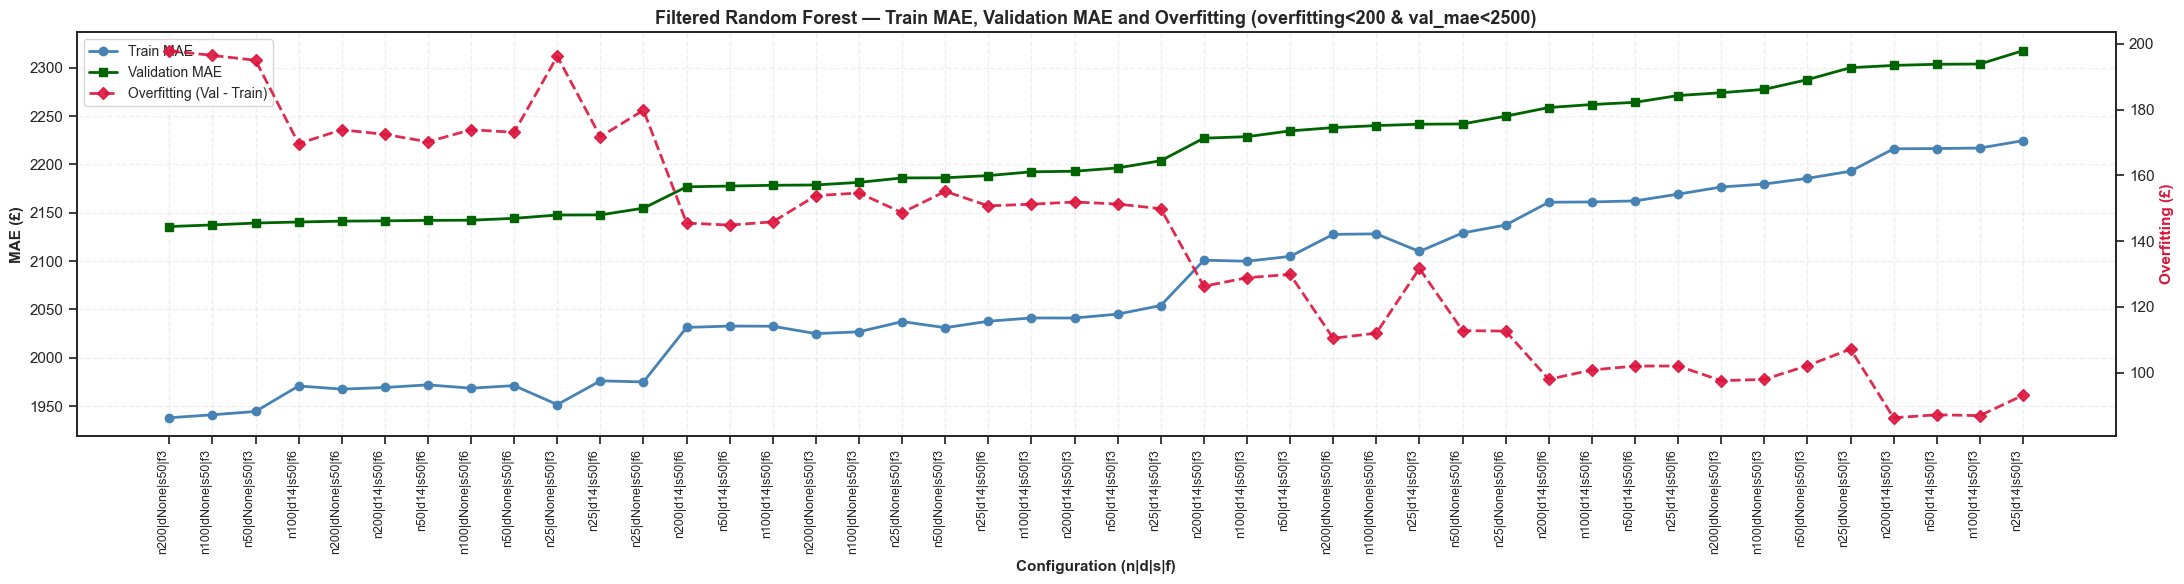


Filtered configurations (top 15 by val_mae):


,n_estimators,max_depth,min_samples_split,max_features,max_samples,train_mae,val_mae,overfitting,label
0,200,NaN,50,3,1.00,1937.824072,2135.705085,197.881012,n200|dNone|s50|f3
1,100,NaN,50,3,1.00,1940.913360,2137.351949,196.438589,n100|dNone|s50|f3
2,50,NaN,50,3,1.00,1944.334756,2139.311631,194.976875,n50|dNone|s50|f3
3,100,14.0,50,6,1.00,1970.754640,2140.389151,169.634511,n100|d14|s50|f6
4,200,NaN,50,6,0.66,1967.441879,2141.281556,173.839677,n200|dNone|s50|f6
5,200,14.0,50,6,1.00,1969.154962,2141.599930,172.444969,n200|d14|s50|f6
6,50,14.0,50,6,1.00,1971.890127,2142.068373,170.178247,n50|d14|s50|f6
7,100,NaN,50,6,0.66,1968.405251,2142.260484,173.855233,n100|dNone|s50|f6
8,50,NaN,50,6,0.66,1971.112436,2144.182661,173.070226,n50|dNone|s50|f6
9,25,NaN,50,3,1.00,1951.456096,2147.625160,196.169064,n25|dNone|s50|f3


In [ ]:
# Recreate the filtered dataframe (in case df_filtered isn't in memory)
df = df_rf_models.copy()
df_filtered = df[(df["overfitting"] < 200) & (df["val_mae"] < 2500)].reset_index(drop=True)

# Build compact labels inline (no separate function)
df_filtered["label"] = df_filtered.apply(
    lambda r: f"n{int(r['n_estimators'])}|d{'None' if pd.isna(r['max_depth']) else int(r['max_depth'])}|s{int(r['min_samples_split'])}|f{int(r['max_features'])}",
    axis=1
)

# Sort by validation MAE for readability
df_filtered = df_filtered.sort_values("val_mae").reset_index(drop=True)

x = np.arange(len(df_filtered))

# Scale figure width to number of labels so all labels remain legible
fig_width = max(14, min(60, len(df_filtered) * 0.5))
fig, ax1 = plt.subplots(figsize=(fig_width, 6))

# Primary y-axis: train & validation MAE (lines)
ax1.plot(x, df_filtered["train_mae"], marker='o', linestyle='-', linewidth=2, color='steelblue', label='Train MAE')
ax1.plot(x, df_filtered["val_mae"],   marker='s', linestyle='-', linewidth=2, color='darkgreen', label='Validation MAE')
ax1.set_xlabel("Configuration (n|d|s|f)", fontsize=11, fontweight='bold')
ax1.set_ylabel("MAE (£)", fontsize=11, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.3)

# Secondary y-axis: overfitting as a LINE
ax2 = ax1.twinx()
ax2.plot(x, df_filtered["overfitting"], marker='D', linestyle='--', linewidth=2, color='crimson', label='Overfitting (Val - Train)', alpha=0.9)
ax2.set_ylabel("Overfitting (£)", fontsize=11, fontweight='bold', color='crimson')

# Show ALL x labels
ax1.set_xticks(x)
ax1.set_xticklabels(df_filtered["label"].tolist(), rotation=90, ha='right', fontsize=9)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title("Filtered Random Forest — Train MAE, Validation MAE and Overfitting (overfitting<200 & val_mae<2500)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Display filtered table (top 15 by val_mae)
print("\nFiltered configurations (top 15 by val_mae):")
display(df_filtered.head(15))



Now we will see a robust MAE score using CV for this best RF model.

In [7]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = RandomForestRegressor(random_state=22,
                                n_estimators = 50,
                                max_depth= 14,
                                min_samples_split= 50,
                                max_features= 6,
                                max_samples= 0.66,
                                bootstrap=True,
                                criterion='absolute_error',
                                n_jobs=-1),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'RF',
            log_transform= True)

6it [50:59, 510.00s/it]


In [8]:
print_cv_results('RF', dic_train_MAE, dic_val_MAE)

CV Results - RF
Train MAE: 2026.07, Train std: 5.67
Validation MAE: 2174.54, Validatin std: 30.37


The best Random Forest (RF) model achieved a mean validation MAE of £2174, with an overfitting gap (the difference between training MAE and validation MAE) of £148 on average terms.

Let's now analyze the actual vs. predicted values of that model.

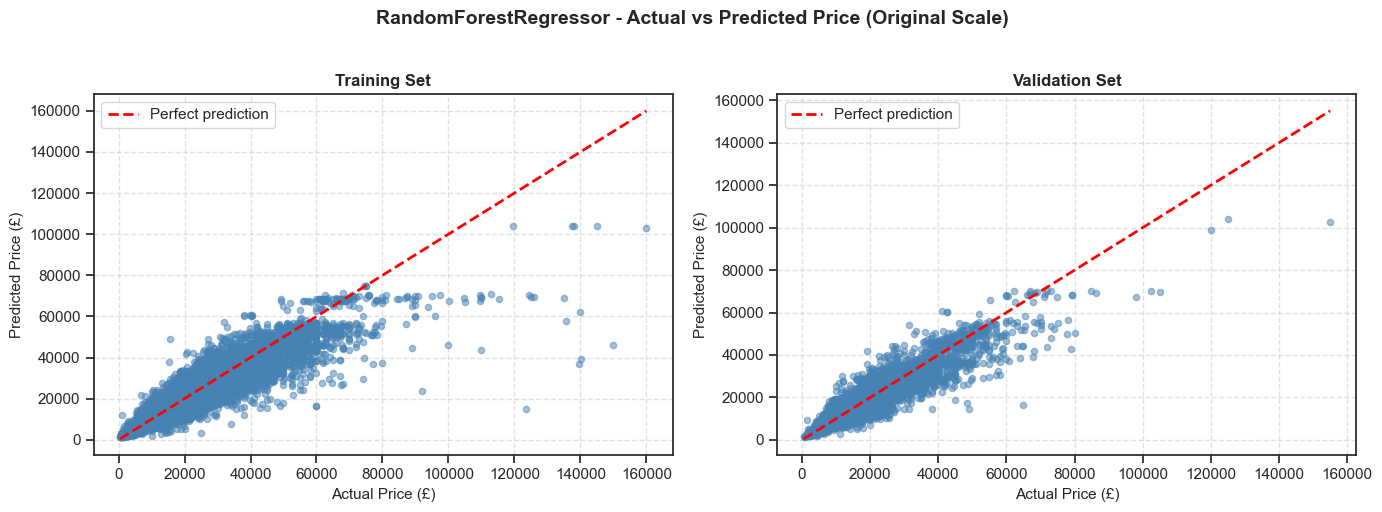

In [9]:
RF_model = RandomForestRegressor(random_state=22,
                                n_estimators = 50,
                                max_depth= 14,
                                min_samples_split= 50,
                                max_features= 6,
                                max_samples= 0.66,
                                bootstrap=True,
                                criterion='absolute_error',
                                n_jobs=-1)

graph_actual_vs_predicted(RF_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

After seeing the predictions, we observe that the model predicts well for the training and validation sets. There are still some 'ladders' of values like on the Decision Tree (DT) for high values, but it captures the relationships of the variables with the target better. Of course, it performs better for lower values of the price, but it is the best one overall so far for the validation.

### <a id='toc4_1_5_'></a>[AdaBoost](#toc0_)

We will test how the AdaBoost Regressor performs.

To test it, we are going to use the linear loss (which is the absolute error, since that is the metric we want to optimize). The base estimator will be a very simple Decision Tree (DT) Regressor with a maximum depth equal to 4 that uses absolute error as the evaluation criterion.

For the number of estimators, since this is the only hyperparameter we are trying to optimize, we will test a small number of them (50), a large number (200), and some values in the middle (100, 150).

In [ ]:
# Define the parameters to test
param_grid = {
    "n_estimators": [50, 100, 150, 200],        
}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_ADA = {}
dic_val_score_ADA = {}

In [ ]:
for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = AdaBoostRegressor(estimator= DecisionTreeRegressor(criterion='absolute_error', max_depth = 4, random_state = 22),
                                         n_estimators= params['n_estimators'], 
                                         learning_rate= 1.0, 
                                         loss= 'linear', 
                                         random_state= 22),
               score_train_dic = dic_train_score_ADA,
               score_val_dic = dic_val_score_ADA,
               dic_key = params['n_estimators'],
               log_transform= True)

100%|██████████| 4/4 [13:31:25<00:00, 12171.39s/it]


Now we will see the results of the MAE of train and validation to choose the best hyperparamater for our ADABoost.

In [ ]:
# Create DataFrame from AdaBoost dictionaries
rows = []
for n_estimators in sorted(dic_train_score_ADA.keys()):
    train_mae = float(dic_train_score_ADA[n_estimators])
    val_mae = float(dic_val_score_ADA[n_estimators])
    rows.append({
        "n_estimators": n_estimators,
        "train_mae": train_mae,
        "val_mae": val_mae,
        "overfitting": val_mae - train_mae
    })

df_ada_models = pd.DataFrame(rows)

df_ada_models

,n_estimators,train_mae,val_mae,overfitting
0,50,3020.906182,3014.456494,-6.449688
1,100,3129.745354,3124.454072,-5.291282
2,150,3238.525115,3242.984948,4.459833
3,200,3308.616273,3314.657395,6.041122


The results are far from good; the models are not performing well, and the majority even underfit. So, the normal approach in AdaBoost, which is to build simpler trees, is not working (even for a large number of estimators).

For that reason, we are going to test with a smaller number of estimators (5, 10, 20) and increase the complexity of the base estimator, allowing a maximum depth of 10 and 14 (since these are the extreme values of depth for the single Decision Tree (DT) that started to achieve some meaningful results).

In [ ]:
# Define the parameters to test
param_grid = {
    "n_estimators": [5, 10, 20],
    'max_depth': [10, 14]        
}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_ADA_2 = {}
dic_val_score_ADA_2 = {}

for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = AdaBoostRegressor(estimator= DecisionTreeRegressor(criterion='absolute_error', max_depth = params['max_depth'], random_state = 22),
                                         n_estimators= params['n_estimators'], 
                                         learning_rate= 1.0, 
                                         loss= 'linear', 
                                         random_state= 22),
               score_train_dic = dic_train_score_ADA_2,
               score_val_dic = dic_val_score_ADA_2,
               dic_key = (params['n_estimators'], params['max_depth']),
               log_transform= True)

Now we will see the results of the MAE of train and validation to choose the best hyperparamater for our new ADABoost.

In [ ]:
# Create DataFrame from AdaBoost dictionaries
rows = []
for n_estimators, max_depth in sorted(dic_train_score_ADA_2.keys()):
    train_mae = float(dic_train_score_ADA_2[(n_estimators,max_depth)])
    val_mae = float(dic_val_score_ADA_2[(n_estimators,max_depth)])
    rows.append({
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "train_mae": train_mae,
        "val_mae": val_mae,
        "overfitting": val_mae - train_mae
    })

df_ada_models = pd.DataFrame(rows)

df_ada_models.sort_values("val_mae").reset_index(drop=True)

,n_estimators,max_depth,train_mae,val_mae,overfitting
0,20,14,1449.546648,2070.502767,620.956119
1,10,14,1490.126316,2071.631186,581.504870
2,5,14,1543.254981,2118.313693,575.058712
3,20,10,2097.328770,2283.527054,186.198284
4,10,10,2115.139174,2292.346097,177.206923
5,5,10,2143.317919,2315.075282,171.757363


Now we see that the MAE results are much better. With very complex trees, we achieve a better Validation MAE and Training MAE score, but the model memorizes the training data (resulting in a very large overfitting).

Therefore, our choice for the best AdaBoost model is the one with a maximum depth of 10 and 5 estimators (n_estimators = 5), which achieved an overfitting difference of £171 and a Validation MAE of £2,315, because it is simpler and does not overfit significantly.

Now we will find a robust MAE score using Cross-Validation (CV) for this best AdaBoost model.

In [12]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = AdaBoostRegressor(estimator= DecisionTreeRegressor(criterion='absolute_error', max_depth = 10, random_state = 22),
                                         n_estimators= 5, 
                                         learning_rate= 1.0, 
                                         loss= 'linear', 
                                         random_state= 22),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'ADA',
            log_transform= True)

6it [44:40, 446.72s/it]


In [13]:
print_cv_results('ADA', dic_train_MAE, dic_val_MAE)

CV Results - ADA
Train MAE: 2131.57, Train std: 10.65
Validation MAE: 2304.99, Validatin std: 24.0


The best AdaBoost regressor model achieved a mean validation MAE of £2304, with an overfitting gap (the difference between training MAE and validation MAE) of £173 on average terms.

Let's now analyze the actual vs. predicted values of that model.

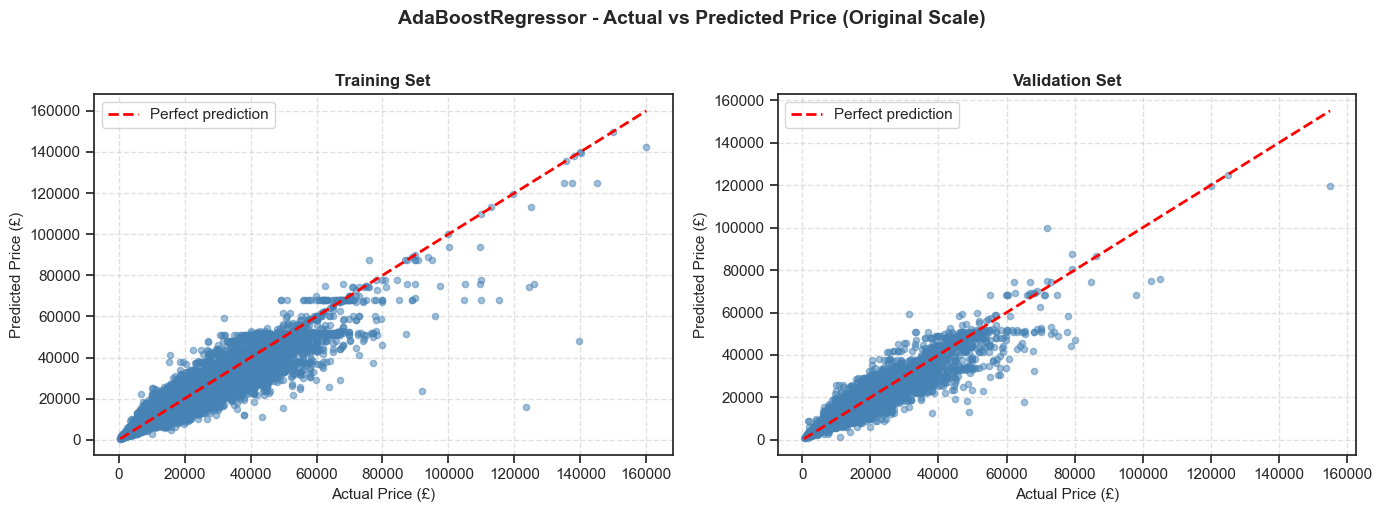

In [ ]:
ADA_model = AdaBoostRegressor(estimator= DecisionTreeRegressor(criterion='absolute_error', max_depth = 10, random_state = 22),
                                         n_estimators= 5, 
                                         learning_rate= 1.0, 
                                         loss= 'linear', 
                                         random_state= 22)

graph_actual_vs_predicted(ADA_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

After seeing the predictions, we observe that even though the model did not have a very good MAE in comparizon with the RF, it predicts well for the training and validation sets across the entire range of values.

### <a id='toc4_1_6_'></a>[Neural Networks (NN)](#toc0_)

We will test how the Neural Networks (NN) Regressor (multilayer perceptron MLP) performs.Now, let's first analyze the number of epochs and the learning rate (initialization and evolution of it). 

To find the optimal settings, we are going to test different NN architectures (simpler and complex) and see how these parameters affect the loss function, and we are going to use as:
+ **Activation Function (relu):** We are using the relu activation function. The Rectified Linear Unit is the standard choice for hidden layers, as it efficiently avoids the vanishing gradient problem in deep networks (when the weights are not being updated).
+ **Solver (sgd):** We are using the sgd solver (Stochastic Gradient Descent). This choice is made because it allows us to control the learning rate evolution.
+ **Learning Rate Schedule (invscaling):** The invscaling method gradually reduces the learning rate over time. This helps the model take large steps early on (to quickly approach the minimum) and smaller steps later (to avoid overshooting the optimal solution).
+ **Sample Control:** We will shuffle the samples at each iteration to prevent the network from learning spurious correlations based on data order, leading to a more robust model.

To test the effects of learning rate and architecture, we will keep most parameters as default, but systematically vary the key hyperparameters: 
+ **Architectures (hidden_layer_sizes):** We will test a simple architecture with 6 hidden units and a more complex one with two layers of 100 units (100, 100). 
+ **Learning Rate Initialization (learning_rate_init):** We will test a range of starting values: 0.01, 0.001, and 0.0001. 
+ **Learning Rate Evolution Control (power_t):** To control how the learning rate is reduced by the invscaling schedule, we will test the effect of different exponents: 0.5, 0.1, and 0.05. 
This targeted testing allows us to observe how the complexity of the network interacts with the speed and stability of the optimization process.

  0%|          | 0/18 [00:00<?, ?it/s]

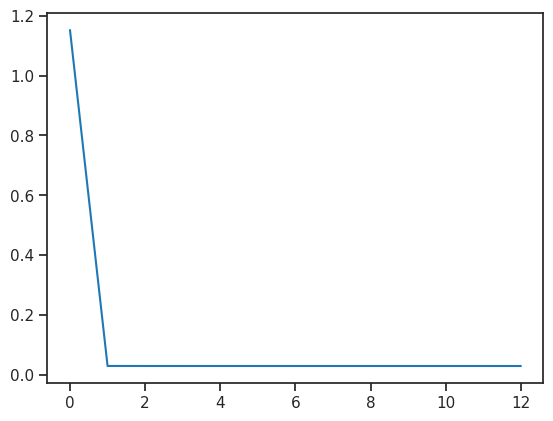

  6%|▌         | 1/18 [00:02<00:38,  2.29s/it]

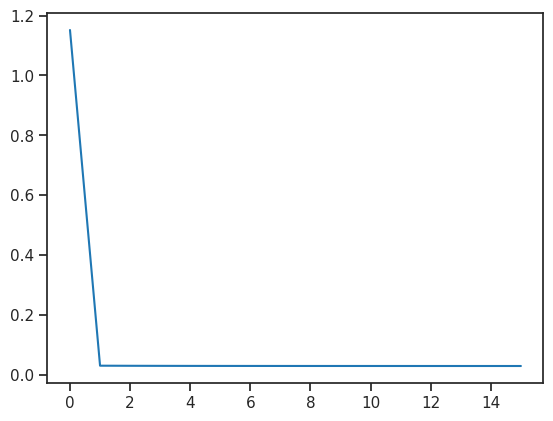

 11%|█         | 2/18 [00:04<00:31,  1.95s/it]

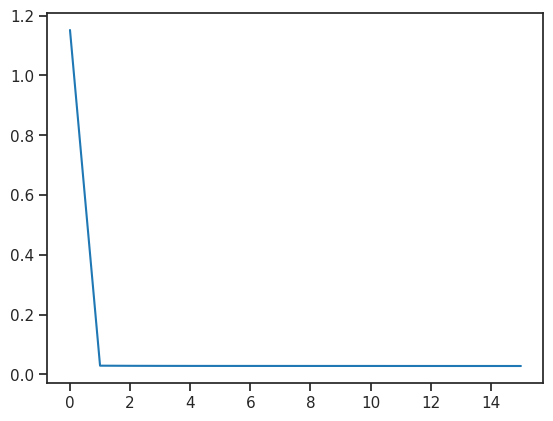

 17%|█▋        | 3/18 [00:05<00:23,  1.56s/it]

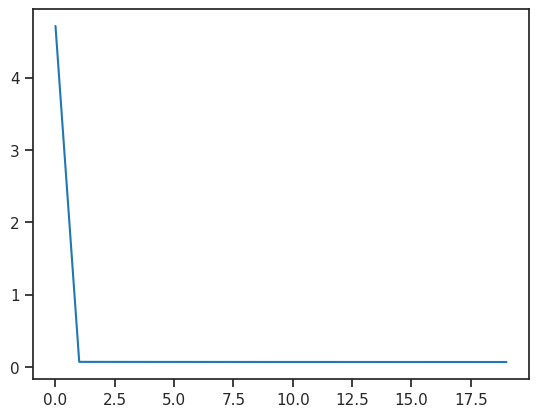

 22%|██▏       | 4/18 [00:06<00:20,  1.43s/it]

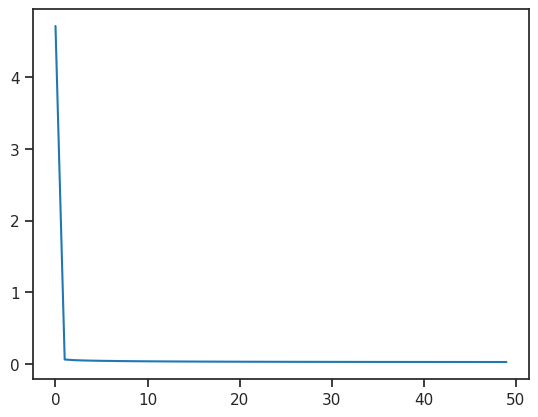

 28%|██▊       | 5/18 [00:09<00:26,  2.01s/it]

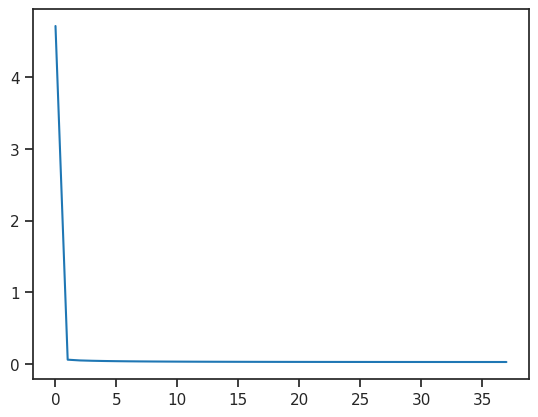

 33%|███▎      | 6/18 [00:11<00:25,  2.13s/it]

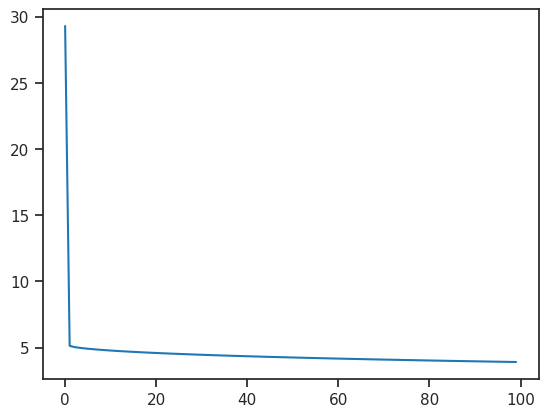

 39%|███▉      | 7/18 [00:19<00:42,  3.86s/it]

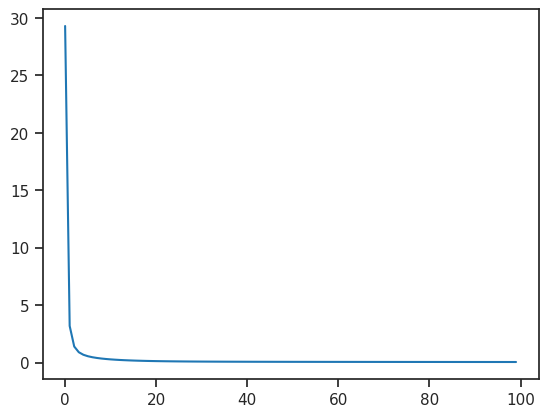

 44%|████▍     | 8/18 [00:24<00:44,  4.48s/it]

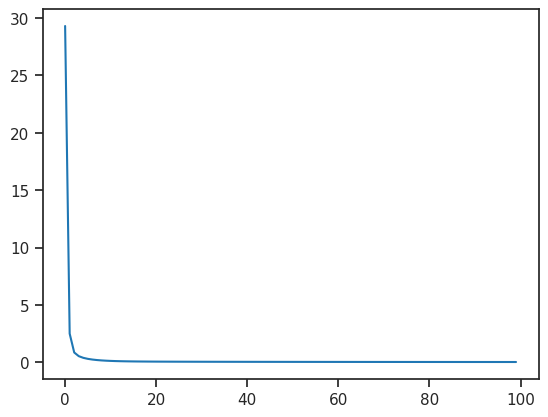

 50%|█████     | 9/18 [00:31<00:47,  5.26s/it]

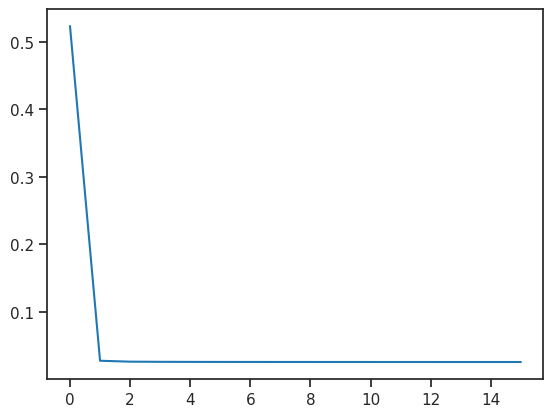

 56%|█████▌    | 10/18 [00:39<00:47,  5.94s/it]

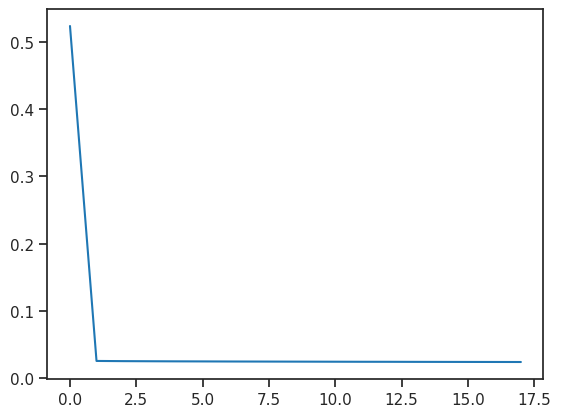

 61%|██████    | 11/18 [00:51<00:53,  7.70s/it]

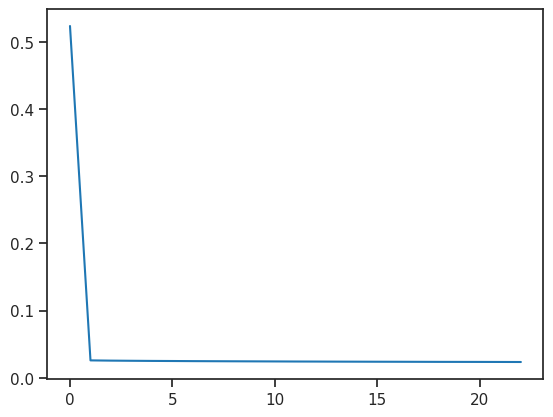

 67%|██████▋   | 12/18 [01:04<00:57,  9.58s/it]

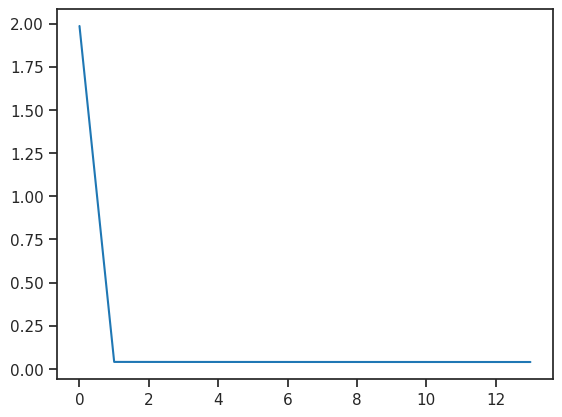

 72%|███████▏  | 13/18 [01:14<00:48,  9.65s/it]

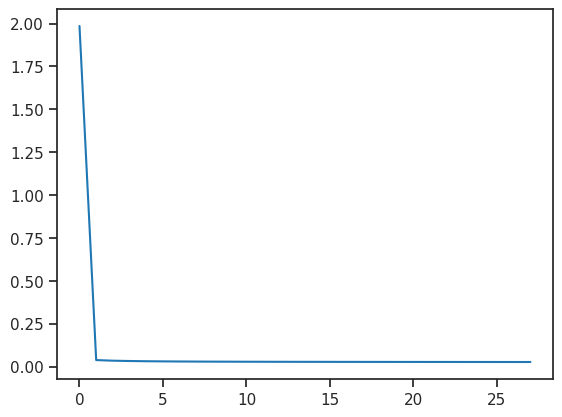

 78%|███████▊  | 14/18 [01:31<00:47, 11.82s/it]

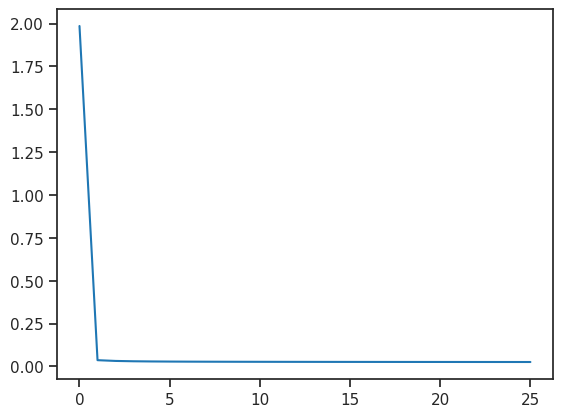

 83%|████████▎ | 15/18 [01:46<00:38, 12.88s/it]

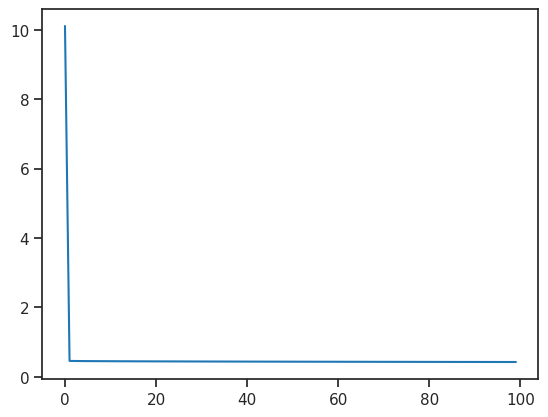

 89%|████████▉ | 16/18 [02:45<00:53, 26.76s/it]

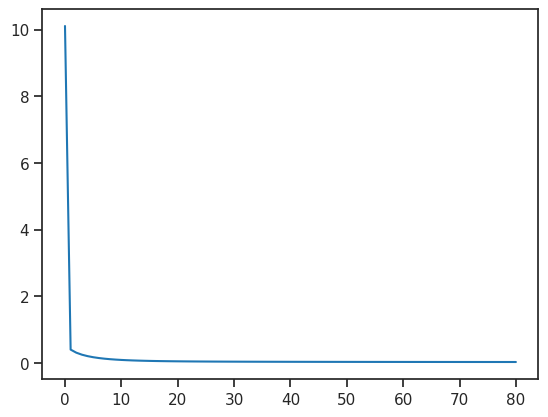

 94%|█████████▍| 17/18 [04:21<00:47, 47.34s/it]

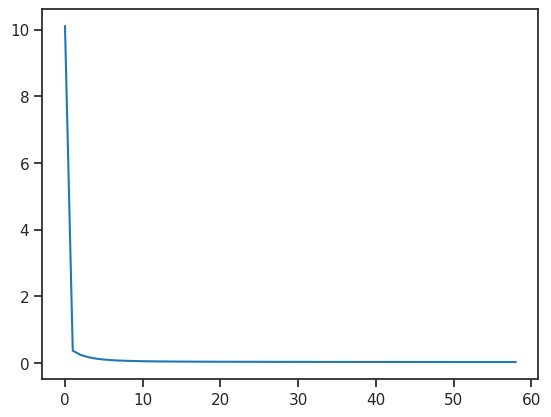

100%|██████████| 18/18 [05:47<00:00, 19.29s/it]


In [ ]:
# Define the parameters to test
param_grid = {
    "learning_rate_init": [0.01,0.001,0.0001],
    "power_t" : [0.5, 0.1, 0.05],
    'hidden_layer_sizes' : [6, (100,100)]
}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_NN_test = {}
dic_val_score_NN_test = {}

for parms in tqdm(grid):
      NN_model_LR_test = MLPRegressor(hidden_layer_sizes=parms['hidden_layer_sizes'],
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init=parms['learning_rate_init'],
                  power_t = parms['power_t'],
                  max_iter=100,
                  shuffle=True,
                  random_state=22)

      NN_model_LR_test.fit(X_train_HO, y_train_HO)

      dic_train_score_NN_test[(parms['hidden_layer_sizes'],parms['learning_rate_init'],parms['power_t'])] = mean_absolute_error(np.exp(y_train_HO), np.exp(NN_model_LR_test.predict(X_train_HO)))
      dic_val_score_NN_test[(parms['hidden_layer_sizes'],parms['learning_rate_init'],parms['power_t'])] = mean_absolute_error(np.exp(y_val_HO), np.exp(NN_model_LR_test.predict(X_val_HO)))
      losses = NN_model_LR_test.loss_curve_
      iterations = range(NN_model_LR_test.n_iter_)
      sns.lineplot(x = iterations, y = losses)
      plt.show()

First, when we look at the loss curve, regardless of the learning rate, the model converges very fast (it doesn't need that many iterations). For that reason, we are going to establish max_iter = 20. This number is small enough, yet it was a limit that none of our test cases reached, ensuring we capture full convergence.

And let's analyze our results for the learning rate analysis.

In [ ]:
# Create DataFrame from NN dictionaries
rows = []
for hidden_layer_sizes, learning_rate_init, power_t in dic_train_score_NN_test.keys():
    train_mae = float(dic_train_score_NN_test[(hidden_layer_sizes, learning_rate_init, power_t)])
    val_mae = float(dic_val_score_NN_test[(hidden_layer_sizes, learning_rate_init, power_t)])
    rows.append({
        'hidden_layer_sizes': hidden_layer_sizes,
        'learning_rate_init': learning_rate_init,
        'power_t': power_t,
        "train_mae": round(train_mae,1),
        "val_mae": round(val_mae,1),
        "overfitting": round(val_mae - train_mae,2)
    })

df_NN_models = pd.DataFrame(rows)

df_NN_models

,hidden_layer_sizes,learning_rate_init,power_t,train_mae,val_mae,overfitting
0,6,0.0100,0.50,3095.5,3103.8,8.37
1,6,0.0100,0.10,3000.4,3011.4,11.06
2,6,0.0100,0.05,2991.6,3005.3,13.75
3,6,0.0010,0.50,4618.3,4602.9,-15.37
4,6,0.0010,0.10,3020.5,3044.3,23.87
5,6,0.0010,0.05,2994.3,3013.6,19.38
6,6,0.0001,0.50,31701666.8,2081569.8,-29620096.98
7,6,0.0001,0.10,3672.8,3680.2,7.43
8,6,0.0001,0.05,3262.8,3285.3,22.52
9,"(100, 100)",0.0100,0.50,2851.1,2862.4,11.24


In [ ]:
df_NN_models.groupby(['learning_rate_init', 'power_t'])[['train_mae', 'val_mae', 'overfitting']].mean()

train_mae      val_mae   overfitting
learning_rate_init power_t                                        
0.0001             0.05         3143.50      3150.20  6.735000e+00
                   0.10         3418.70      3409.20 -9.495000e+00
                   0.50     84545047.30  41350946.75 -4.319410e+07
0.0010             0.05         2911.40      2928.95  1.757500e+01
                   0.10         2944.75      2962.30  1.759500e+01
                   0.50         4226.95      4158.35 -6.859000e+01
0.0100             0.05         2849.90      2870.30  2.041500e+01
                   0.10         2880.20      2897.95  1.776000e+01
                   0.50         2973.30      2983.10  9.805000e+00

We see that the model's behavior changes accordingly depending on the learning rate. The best performance (lowest MAE) was achieved when the **learning rate starts at 0.01**, which provided the best general results across all tested power_t values. For the learning rate reduction schedule, we will use the **power_t value of 0.05**, as it yielded the lowest MAE overall.

Now we will analyze the architecture to find overfitting and underfitting layers. We will take into consideration the following design principles:
+ **First Hidden Layer Size:** Our first hidden layer needs to have more units than the number of input features to better understand the data and capture complex relationships.
+ **Subsequent Layers (Pyramid Structure):** If we add more layers, we will reduce (or maintain) their size sequentially, maintaining the general shape of a pyramid  in our hidden units.

Let's start with underfitting.

In [ ]:
NN_model_UF = MLPRegressor(hidden_layer_sizes=16,
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22)

model_performance(NN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 3010.9723159947885
Validation MAE: 3007.0962324507195


We see that starting using only 16 neurons in the hidden layer causes the model to underfit.

Let's continue to see when the model starts to overfit.

In [ ]:
NN_model_OF = MLPRegressor(hidden_layer_sizes=(128,64),
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22)

model_performance(NN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2723.717154191883
Validation MAE: 2749.4721911257743


In [4]:
NN_model_OF = MLPRegressor(hidden_layer_sizes=(128,64,32),
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22)

model_performance(NN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2691.7850153465315
Validation MAE: 2716.060507751488


In [ ]:
NN_model_OF = MLPRegressor(hidden_layer_sizes=(128,64,32,16),
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22)

model_performance(NN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2675.9189815656036
Validation MAE: 2700.8322064244753


In [ ]:
NN_model_OF = MLPRegressor(hidden_layer_sizes=(128,64,32,16,8),
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22)

model_performance(NN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2669.8660655174667
Validation MAE: 2690.073635327283


In [ ]:
NN_model_OF = MLPRegressor(hidden_layer_sizes=(128,64,64,32),
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22)

model_performance(NN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2660.2576488179056
Validation MAE: 2690.6942860163845


In [ ]:
NN_model_OF = MLPRegressor(hidden_layer_sizes=(256,128,64,32),
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22)

model_performance(NN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2680.1627530504975
Validation MAE: 2701.6482710467117


After seeing the results, we can conclude the following: using up to 4 hidden layers represents an improvement (even if it's small). However, using more than 128 neurons in the first layer does not add more value to the model.

So, for our final Grid Search, we are going to test architectures that fall between a minimum of 1 hidden layer with only 16 neurons (the point of underfitting) and a maximum of 4 hidden layers that have 128 neurons on the first layer (the point of diminishing returns).

In [7]:
# Define the parameters to test
param_grid = {
    "hidden_layer": [16, 32, 64, 128, 
                     (32,32), (32,16), (64,64), (64,32), (128,128), (128,64), 
                     (128,64,32), (128,128,64), (64,32,16), (64,64,32), (32,16,8), (32,32,16),
                     (128,64,32,16), (128,64,64,32)]
}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_NN = {}
dic_val_score_NN = {}

In [8]:
for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = MLPRegressor(hidden_layer_sizes=params['hidden_layer'],
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22),
               score_train_dic = dic_train_score_NN,
               score_val_dic = dic_val_score_NN,
               dic_key = params['hidden_layer'],
               log_transform= True)

100%|██████████| 18/18 [03:37<00:00, 12.09s/it]


Now we will see the results of the MAE of train and validation to choose the best hyperparamater for our Neural Network (NN).

In [10]:
# Create DataFrame from NN dictionaries
rows = []
for hidden_layer in dic_train_score_NN.keys():
    train_mae = float(dic_train_score_NN[hidden_layer])
    val_mae = float(dic_val_score_NN[hidden_layer])
    rows.append({
        "hidden_layer": hidden_layer,
        "train_mae": train_mae,
        "val_mae": val_mae,
        "overfitting": val_mae - train_mae
    })

df_NN_models = pd.DataFrame(rows)

df_NN_models.sort_values("val_mae").reset_index(drop=True)

,hidden_layer,train_mae,val_mae,overfitting
0,"(128, 64, 64, 32)",2660.257649,2690.694286,30.436637
1,"(128, 64, 32, 16)",2675.918982,2700.832206,24.913225
2,"(128, 64, 32)",2691.785015,2716.060508,24.275492
3,"(128, 128, 64)",2700.357847,2719.183871,18.826024
4,"(64, 32, 16)",2701.441404,2734.457023,33.015619
5,"(64, 64)",2719.691974,2743.339359,23.647385
6,"(128, 128)",2715.238065,2748.814909,33.576844
7,"(128, 64)",2723.717154,2749.472191,25.755037
8,"(64, 32)",2727.772846,2751.994823,24.221977
9,"(32, 32)",2752.951622,2759.142455,6.190833


After seeing the results, we observed that the model with the lowest MAE on validation (around 2690£) were the ones with (128, 64, 64, 32)	 hidden_layers, it exhibited an overfitting of approximately £30.

Now we will see a robust MAE score using CV for this best Neural Network model.

In [14]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = MLPRegressor(hidden_layer_sizes=(128, 64, 64, 32),
                  activation='relu',
                  solver='sgd',
                  learning_rate='invscaling',
                  learning_rate_init= 0.01,
                  power_t = 0.05,
                  max_iter=20,
                  shuffle=True,
                  random_state=22),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'NN',
            log_transform= True)

6it [05:43, 57.33s/it]


In [15]:
print_cv_results('NN', dic_train_MAE, dic_val_MAE)

CV Results - NN
Train MAE: 2671.08, Train std: 13.27
Validation MAE: 2684.4, Validatin std: 25.16


The best MLP regressor model achieved a mean validation MAE of £2684, with an overfitting gap (the difference between training MAE and validation MAE) of £13 on average terms.

Let's now analyze the actual vs. predicted values of that model.

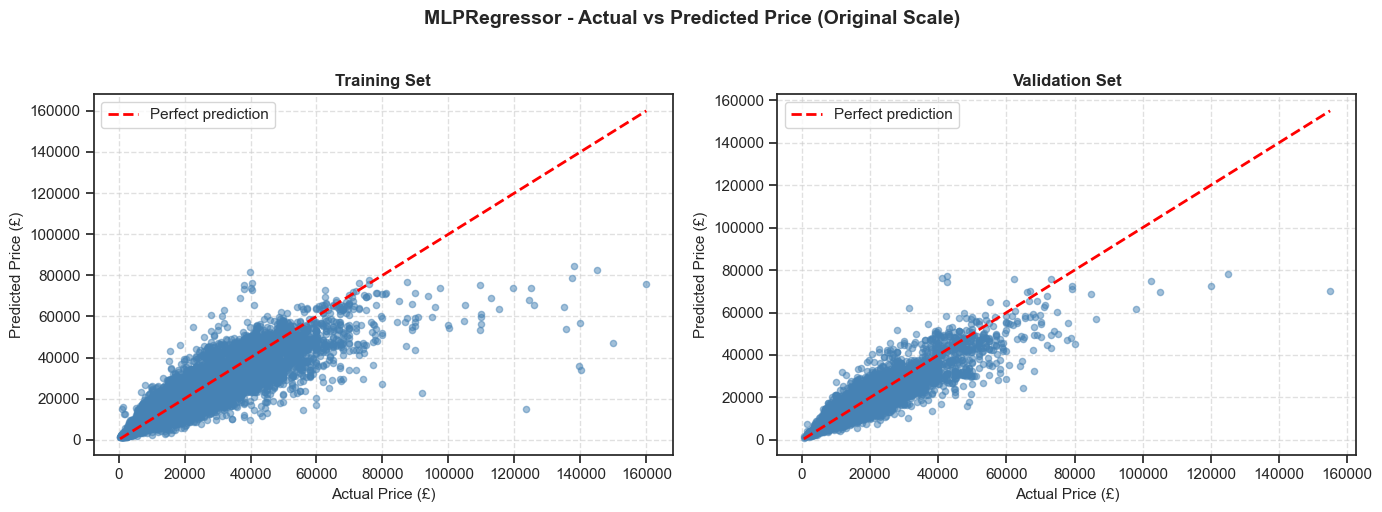

In [15]:
NN_model = MLPRegressor(hidden_layer_sizes=(128, 64, 64, 32), 
             activation='relu', 
             solver='sgd', 
             learning_rate='invscaling',
             learning_rate_init=0.01, 
             power_t = 0.1,
             max_iter=30, 
             shuffle=True,
             random_state=22)

graph_actual_vs_predicted(NN_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

After seeing the predictions, we observe that the model predicts adequately for the training and validation sets, and is not overfitting. However, it did not capture the relationship of the price when it is high.

### <a id='toc4_1_7_'></a>[Analysis Final Model](#toc0_)

To analyze which is going to be our final model, we will evaluate the Mean Absolute Error (MAE) for the training and validation sets using Cross-Validation (CV), considering the overfitting gap, the standard deviation of the CV results, and the model complexity.

In [11]:
# Create DataFrame from CV dictionaries
rows = []
for model in dic_train_MAE.keys():
    train_mae = dic_train_MAE[model]
    val_mae = dic_val_MAE[model]
    rows.append({
        "model": model,
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    })

df_CV_models = pd.DataFrame(rows)

df_CV_models.sort_values("val_mae").reset_index(drop=True)

,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
0,RF,2026.07,2174.54,148.47,5.67,30.37
1,ADA,2131.57,2304.99,173.42,10.65,24.00
2,DT,2390.33,2477.05,86.72,11.53,30.00
3,KNN,2458.43,2503.04,44.61,6.57,27.28
4,NN,2671.08,2684.40,13.32,13.27,25.16
5,LR-BeanchMark,3035.19,3034.63,-0.56,11.87,49.57


So, because the mean validation MAE on the Random Forest (RF) is the lowest (2174£), and because it had an overfitting gap less than 200, we will consider this as our final model for the Random Forest Regressor for now.

Before deciding on the final model, we will test if the model performs better without the log transformation on the target variable (price). To do this, we will evaluate the score using Cross-Validation (CV) on the best models.

In [12]:
final_models = [('LR-BeanchMark', LinearRegression()),
               
               ('KNN', KNeighborsRegressor(n_neighbors=59, weights='uniform')),

               ('DT', DecisionTreeRegressor(criterion='absolute_error', 
                                     max_depth = 11,
                                     min_samples_split = 250,
                                     random_state = 22)),
               
               ('RF', RandomForestRegressor(random_state=22,
                                n_estimators = 50,
                                max_depth= 14,
                                min_samples_split= 50,
                                max_features= 6,
                                max_samples= 0.66,
                                bootstrap=True,
                                criterion='absolute_error',
                                n_jobs=-1)),
                                
               ('ADA', AdaBoostRegressor(estimator= DecisionTreeRegressor(criterion='absolute_error', max_depth = 10, random_state = 22),
                                n_estimators= 5, 
                                learning_rate= 1.0, 
                                loss= 'linear', 
                                random_state= 22)),

               ('NN', MLPRegressor(hidden_layer_sizes=(128, 64, 64, 32), 
                            activation='relu', 
                            solver='sgd', 
                            learning_rate='invscaling',
                            learning_rate_init=0.01, 
                            power_t = 0.1,
                            max_iter=30, 
                            shuffle=True,
                            random_state=22))]

dic_train_MAE_nolog = {}
dic_val_MAE_nolog = {}

In [ ]:
for key, model in final_models:
    avg_scores(X = X_CV,
                y = np.exp(y_CV),
                CV = method_CV,
                imputer = KNNImputer(n_neighbors=10, weights='uniform'),
                scalar = RobustScaler(),
                model = model,
                score_train_dic = dic_train_MAE_nolog,
                score_val_dic = dic_val_MAE_nolog,
                dic_key = key,
                log_transform= False)

And now, let's see the results.

In [18]:
# Create DataFrame from CV dictionaries
rows = []
for model in dic_train_MAE_nolog.keys():
    train_mae = dic_train_MAE_nolog[model]
    val_mae = dic_val_MAE_nolog[model]
    rows.append({
        "model": model,
        "train_mae": train_mae[0],
        "val_mae": val_mae[0],
        "overfitting": val_mae[0] - train_mae[0],
        "std_train_mae": train_mae[1],
        "std_val_mae": val_mae[1]
    })

df_CV_models_nolog = pd.DataFrame(rows)

df_CV_models_nolog.sort_values("val_mae").reset_index(drop=True)

,model,train_mae,val_mae,overfitting,std_train_mae,std_val_mae
0,RF,2023.22,2175.13,151.91,4.74,31.58
1,ADA,2170.16,2357.18,187.02,13.82,22.94
2,DT,2391.70,2477.98,86.28,14.14,26.12
3,KNN,2469.69,2516.29,46.60,6.85,32.68
4,NN,2761.84,2780.13,18.29,18.07,30.61
5,LR-BeanchMark,3487.89,3487.80,-0.09,7.99,34.46


So because the validation scores and overfitting did not improve, we will not use the normal scale and keep training the **model on the logarithmic scale of the price.**

That being said, our **final model to estimate the price of the cars is a Bagging of Decision Trees that is trained on the logarithmic transformation of the price of cars, and has the following hyperparameters: estimators = 50, max_depth = 14, min_samples_split = 50, max_features = 6, max_samples = 0.66, bootstrap = True, criterion = 'absolute_error'.**

#### <a id='toc4_1_7_1_'></a>[Final Model](#toc0_)

Now we will train our final model to predict on our test set.

In [19]:
best_model = RandomForestRegressor(random_state=22,
                                n_estimators = 50,
                                max_depth= 14,
                                min_samples_split= 50,
                                max_features= 6,
                                max_samples= 0.66,
                                bootstrap=True,
                                criterion='absolute_error',
                                n_jobs=-1)

best_model.fit(X_full,y_full)

,n_estimators,50
,criterion,'absolute_error'
,max_depth,14
,min_samples_split,50
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# <a id='toc5_'></a>[Deployment (Prediction)](#toc0_)

We will apply all transformations made to the training dataset onto the test set (since this will serve like a proof of concept). We will use the encoder, scaler, imputer, etc, that were already trained on the full training data, apply them to our test dataset, use our best model, and make predictions.

In [20]:
dict_brand_mapping, dict_transmission_mapping, columns_X, encoder = pd.read_pickle('../project_data/DicBrand_DicTrans_columns_PrePro.pkl')

In [21]:
df_test = pd.read_csv('../project_data/test.csv')

In [22]:
df_test_predicted = predict_test_set(
    test_df = df_test,
    dict_brand_mapping = dict_brand_mapping,
    dict_transmission_mapping = dict_transmission_mapping,
    actual_year = 2021, 
    mode_to_fill_transmission = mode_transmission_full,
    train_columns = columns_X,
    encoder = encoder,
    scaler = scaler_full,
    imputer = inputer_full,
    model = best_model,
    filename= 'Group02_Version03',
    log_transform = True
)

In [23]:
df_test_predicted.head()

,price
carID,
89856,22014.569930
106581,21709.714680
80886,11710.927900
100174,16574.821701
81376,25709.545112
